In [1]:
pip install omadb  pandas seaborn numpy scipy pyham SPARQLWrapper

Note: you may need to restart the kernel to use updated packages.


In [77]:
#first lets grab some genes of interest from uniprot.
#I'll just be pulling these with a GO term from the human proteome
#we need the BGEE crossref for some of the analysis we do at the end
#You could use any list of genes from any organism in uniprot as a starting point
#I've capped the number of proteins at 50 for the sake of brevity in these calculations
#but feel free to change this...

import urllib.parse
import urllib.request

def unirequest_tab(GOterm):
    #this is shamelessly lifted from the uniprot programmatic access page
    url = 'https://www.uniprot.org/uniprot/'
    params = {
    'columns': 'id,entry name,reviewed,protein names,genes,organism,length,database(Bgee)',
    'format': 'tab',
    'query' : 'taxonomy:"Homo sapiens (Human) [9606]" goa:( {} )'.format(GOterm),
    'limit' : 15
    }
    
    data = urllib.parse.urlencode(params)
    
    data = data.encode('utf-8')
    
    req = urllib.request.Request(url, data)
    
    with urllib.request.urlopen(req) as f:
       response = f.read()
    r = response.decode('utf-8')
    return r
#here we pull in our proteins of interest for each biological process

terms = ['canonical Wnt signaling pathway [60070]' ,"TOR signaling [31929]"]#, "BMP signaling pathway [30509]" ]
datasets = { t:unirequest_tab(t) for t in terms}



In [78]:
import pandas as pd
import numpy as np
from io import StringIO

#lets load our queries into some dataframes

queries =[]

for term in datasets:
    df = pd.read_table(StringIO(datasets[term]))
    df['pathway'] = term
    queries.append(df)


#here's our total starting dataset for this tutorial
queries = pd.concat(queries)

#let's use the names each protein has in humans throughout our analysis.
#This should allow us to compare the results of all our different types of analysis
#If the protein doesn't have a name we'll just use the human uniprot identifier

names= { query.Entry:query['Entry name'].split('_')[0]+ ' '+query.pathway for index,query in queries[['Entry','Entry name','pathway']].iterrows() if query['Entry name'] is not np.nan }

In [79]:
#let's take a look at our starting data
queries

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Cross-reference (Bgee),pathway
0,O00512,BCL9_HUMAN,reviewed,B-cell CLL/lymphoma 9 protein (B-cell lymphoma...,BCL9,Homo sapiens (Human),1426,ENSG00000116128;,canonical Wnt signaling pathway [60070]
1,P25054,APC_HUMAN,reviewed,Adenomatous polyposis coli protein (Protein AP...,APC DP2.5,Homo sapiens (Human),2843,ENSG00000134982;,canonical Wnt signaling pathway [60070]
2,Q86UU0,BCL9L_HUMAN,reviewed,B-cell CLL/lymphoma 9-like protein (B-cell lym...,BCL9L DLNB11,Homo sapiens (Human),1499,ENSG00000186174;,canonical Wnt signaling pathway [60070]
3,O14640,DVL1_HUMAN,reviewed,Segment polarity protein dishevelled homolog D...,DVL1,Homo sapiens (Human),695,ENSG00000107404;,canonical Wnt signaling pathway [60070]
4,Q5JTC6,AMER1_HUMAN,reviewed,APC membrane recruitment protein 1 (Amer1) (Pr...,AMER1 FAM123B WTX,Homo sapiens (Human),1135,ENSG00000184675;,canonical Wnt signaling pathway [60070]
5,P54792,DVLP1_HUMAN,reviewed,Putative segment polarity protein dishevelled ...,DVL1P1 DVL DVL1 DVL1L1,Homo sapiens (Human),670,NaN,canonical Wnt signaling pathway [60070]
6,P04628,WNT1_HUMAN,reviewed,Proto-oncogene Wnt-1 (Proto-oncogene Int-1 hom...,WNT1 INT1,Homo sapiens (Human),370,ENSG00000125084;,canonical Wnt signaling pathway [60070]
7,Q9GZT5,WN10A_HUMAN,reviewed,Protein Wnt-10a,WNT10A,Homo sapiens (Human),417,ENSG00000135925;,canonical Wnt signaling pathway [60070]
8,O00744,WN10B_HUMAN,reviewed,Protein Wnt-10b (Protein Wnt-12),WNT10B WNT12,Homo sapiens (Human),389,ENSG00000169884;,canonical Wnt signaling pathway [60070]
9,O00755,WNT7A_HUMAN,reviewed,Protein Wnt-7a,WNT7A,Homo sapiens (Human),349,ENSG00000154764;,canonical Wnt signaling pathway [60070]


In [80]:
from omadb import Client
c = Client()
omadata = {}
#retrieve oma entries
for query in list(queries['Entry']) :    
    try:
        omadata[query] = c.entries.__getitem__(query) 
    except:
        print('err ' +query)

In [81]:
#lets get all orthologoues of entries from human
#in all of the species they're found in
orthologs = {}
for query in omadata:
    orthologs[query] = c.entries.orthologs(omadata[query]['omaid'])

In [82]:
#we can create profiles w just orthology data
#lets use species codes to as columns
profiles = {}
for query in orthologs:
    profiles[query] = {}
    profiles[query]['name'] = names[query]
    for ortho in orthologs[query]:
        spec = ortho['omaid'][0:5]
        if spec not in profiles[query]:
            profiles[query][spec] = 1
        else:
            profiles[query][spec]+=1

#the columns for our matrix are the union of all the species represented across all orthologs
#we need to add in 0s where the orthologs are absent
columns = set([ spec  for query in profiles for spec in profiles[query] ])
for query in profiles:
    profiles[query].update( { spec : 0 for spec in columns if spec not in profiles[query] } )

#we can create a dataframe with this dictionary
orthosdf = pd.DataFrame.from_dict( profiles , orient = 'index')
orthosdf.index = orthosdf.name
orthosdf = orthosdf.drop('name', axis = 1)


In [83]:
orthosdf.head()

,STRR1,CHLAD,CHLSY,CHLAA,PLAFR,SAICN,PYROM,CONA1,SPHMS,BOTFB,...,DEIDV,PHAAN,YEAST,BRADI,PICGU,ASPTN,YEASO,MELCN,ORYNI,SPHTD
name,,,,,,,,,,,,,,,,,,,,,
BCL9 canonical Wnt signaling pathway [60070],1,1,1,1,1,1,1,1,3,1,...,0,0,0,0,0,0,0,0,0,0
APC canonical Wnt signaling pathway [60070],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BCL9L canonical Wnt signaling pathway [60070],0,1,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
DVL1 canonical Wnt signaling pathway [60070],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AMER1 canonical Wnt signaling pathway [60070],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


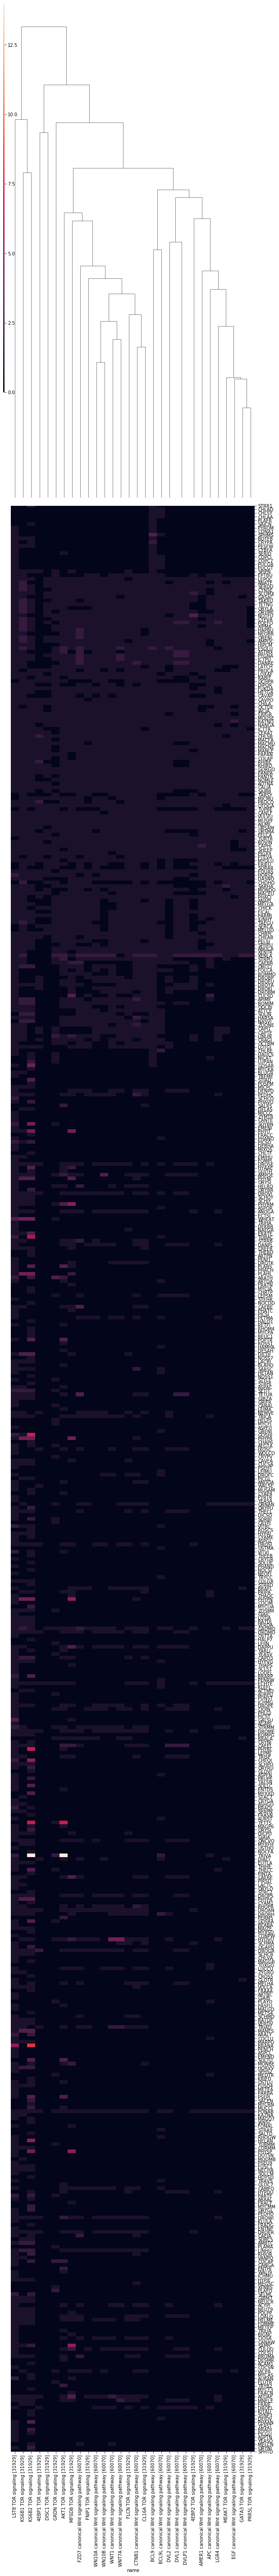

In [84]:
#now that we have our binary vectors of orthologs
#let's import seaborn to visualize the clustering of these functional modules
import seaborn as sns
from matplotlib import pyplot as plt

#and here are some metrics used to compare the vectors to establish a distance kernel

metrics = [ 'euclidean', 'hamming', 'jaccard' ]

#as well as different hierarchical clustering methods

methods = [ 'average' , 'weighted' , 'centroid']

#lets visualize the clustered profile matrix

sns.clustermap( orthosdf.T , metric= metrics[2] , method=methods[1] , col_cluster=True, row_cluster= False, yticklabels = orthosdf.columns , figsize = (10, 100))

#feel free to play around with the different types of metrics

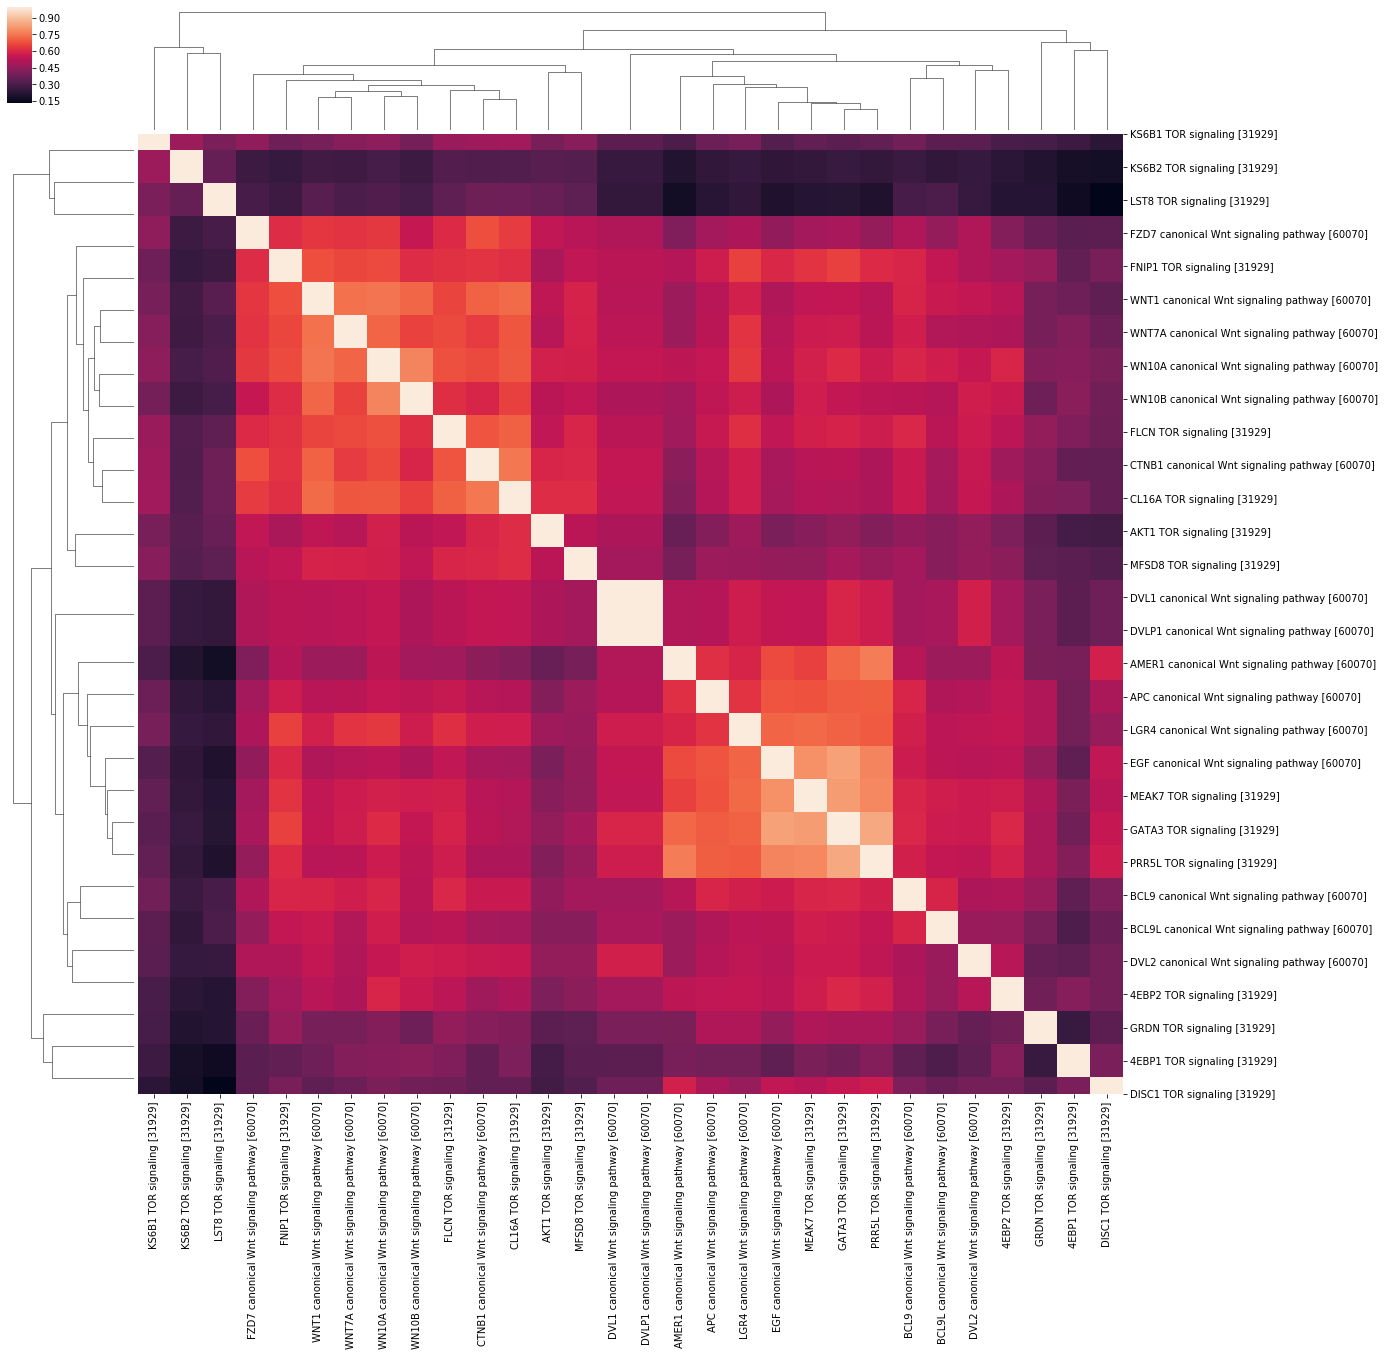

In [85]:
#the last view wasn't very interpretable even though it allows us to see all the 
#different genomes these orthologs are in

#here we directly establish the distance matrix between all profiles before visualising
#It's a more 'module-centric' view were we discard the presence absence information
#and only visulaize the relationship between the sets 

from scipy.spatial.distance import cdist

#let's generate a distance kernel with a distance metric of our choice
distmat = cdist(orthosdf.to_numpy(), orthosdf.to_numpy() , metric = metrics[2])
#and visualize the result
sns.clustermap( 1-distmat , metric= metrics[0] , method=methods[1] , col_cluster=True, row_cluster= True, yticklabels = orthosdf.index , xticklabels = orthosdf.index , figsize = (20, 20))
#much nicer
#MTOR is separate from the olfactory genes!

In [49]:
#now with pyham over the all taxonomic levels with evolutionary events
#extra spicy

#lets try to load HOG data into HAMs and analyze the evolutionary trajectory of each family
import pyham 
database_to_query = 'oma'
Hams = {}
#Pyham can directly access the data in OMA for each of our query genes. we just need to give it
#the ID and it does the rest...usually
for query in omadata:    
    try:
        Hams[query] = pyham.Ham(query_database=omadata[query]['omaid'], use_data_from=database_to_query) 
    except:
        print('err ' + query)


err Q13541
err P31749
err Q13542
err Q2KHT3
err Q3V6T2
err Q8NFG4
err Q6P9B6
err P23443
err Q9UBS0
err Q8TF40
err P23771
err Q9BVC4
err Q6MZQ0
err Q9NRI5
err Q8NHS3
err Q9H2X0
err Q04771
err Q9BU40
err O00400
err P22003
err Q7Z5Y6
err O95813
err P27539
err Q9HCE7
err Q7Z3T8
err P17098
err P49747
err P22004
err P18146
err P43026


In [64]:
#we can look at the evolutionary events that happened to generate the extant distribution of sequences
#for any of the families we were able to retrieve.
hogs = Hams['P17787'].get_dict_top_level_hogs() 
prof = Hams['P17787'].create_tree_profile(outfile="jambon.html")

#we can output an html file with an interactive visualization of the
#HOG's enhanced phylogeny
from IPython.core.display import display, HTML
with open( 'jambon.html') as hamin:
    display(HTML(hamin.read()))

KeyError: 'P17787'

In [65]:
#lets look at how many taxonomic levels and species are in our input matrix
taxaIndex = set([ taxon.name for H in Hams for taxon in Hams[H].taxonomy.tree.traverse() ]) 
species = set( [ taxon.name for H in Hams for taxon in Hams[H].taxonomy.tree.get_leaves()])
print('taxa:'+str(len(taxaIndex)))
print('species:'+str(len(species)))

taxa:0
species:0


In [66]:
profiles = {}
import numpy as np
#we can construct a matrix representing the evolutionary events for each HOG much like 
#we did using the orthologues in the first step
for query in Hams:
    hogs = Hams[query].get_list_top_level_hogs()
    for hog in hogs:    
        profiles[hog.hog_id] = {}
        tp = Hams[query].create_tree_profile(hog = hog).treemap
        
        #here we traverse each annotated tree and record the events in a dictionary
        
        #n is the node in the tree
        #lets check for losses
        losses = { n.name+'_loss': n.lost  for n in tp.traverse() if n.lost  }
        losses.update( { t+'_loss': 0 for t in taxaIndex if t+'_loss' not in losses} )
        
        profiles[hog.hog_id].update(losses)
        
        #now duplication events
        dupl = { n.name+'_dupl': n.dupl for n in tp.traverse() if n.dupl   }
        dupl.update( {t+'_dupl': 0 for t in taxaIndex if t+'_dupl' not in dupl} )
        
        profiles[hog.hog_id].update(dupl)
        
        #and finally infered copy number
        copies = { n.name+'_copies': n.nbr_genes for n in tp.traverse() if n.nbr_genes > 0  }
        nocopies = {t+'_copies': 0 for t in taxaIndex if t+'_copies' not in copies}
        copies.update( nocopies )
        
        profiles[hog.hog_id].update(copies)
        
        #finally let's add the human name information to indicate what this HOG corresponds to
        profiles[hog.hog_id]['name']=  names[query]
        

profile_df = pd.DataFrame.from_dict( profiles , orient = 'index')
profile_df.index = profile_df.index +' : ' + profile_df.name
profile_df = profile_df.drop('name' , axis = 1)


AttributeError: 'DataFrame' object has no attribute 'name'

In [67]:
#again let's take a look at our input data
#this time it includes 3 categories and all taxonomic levels
profile_df.head()

""


In [68]:
#here we can filter the nodes of the species tree we'd like to consider in our analysis
#the intersection of the set of nodes in the subtree and the nodes found in our HOGs
#should reduced the columns in the matrix so we have just a coevolutionary signal from
#a part of the tree of life

selected_taxa = species
#get the species

events = [ '_copies'  , '_dupl' , '_loss']
#we have 3 possible types of events for each node in the species tree
cols = [ t+e for e in events for t in taxaIndex ]

#slice the df to get matrices
sub_df = profile_df.loc[:,cols]
sub_df = sub_df.loc[:, (sub_df != 0).any(axis=0)]
print(sub_df)


Empty DataFrame
Columns: []
Index: []


/home/cactuskid/miniconda3/envs/tfclean/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ValueError: The number of observations cannot be determined on an empty distance matrix.

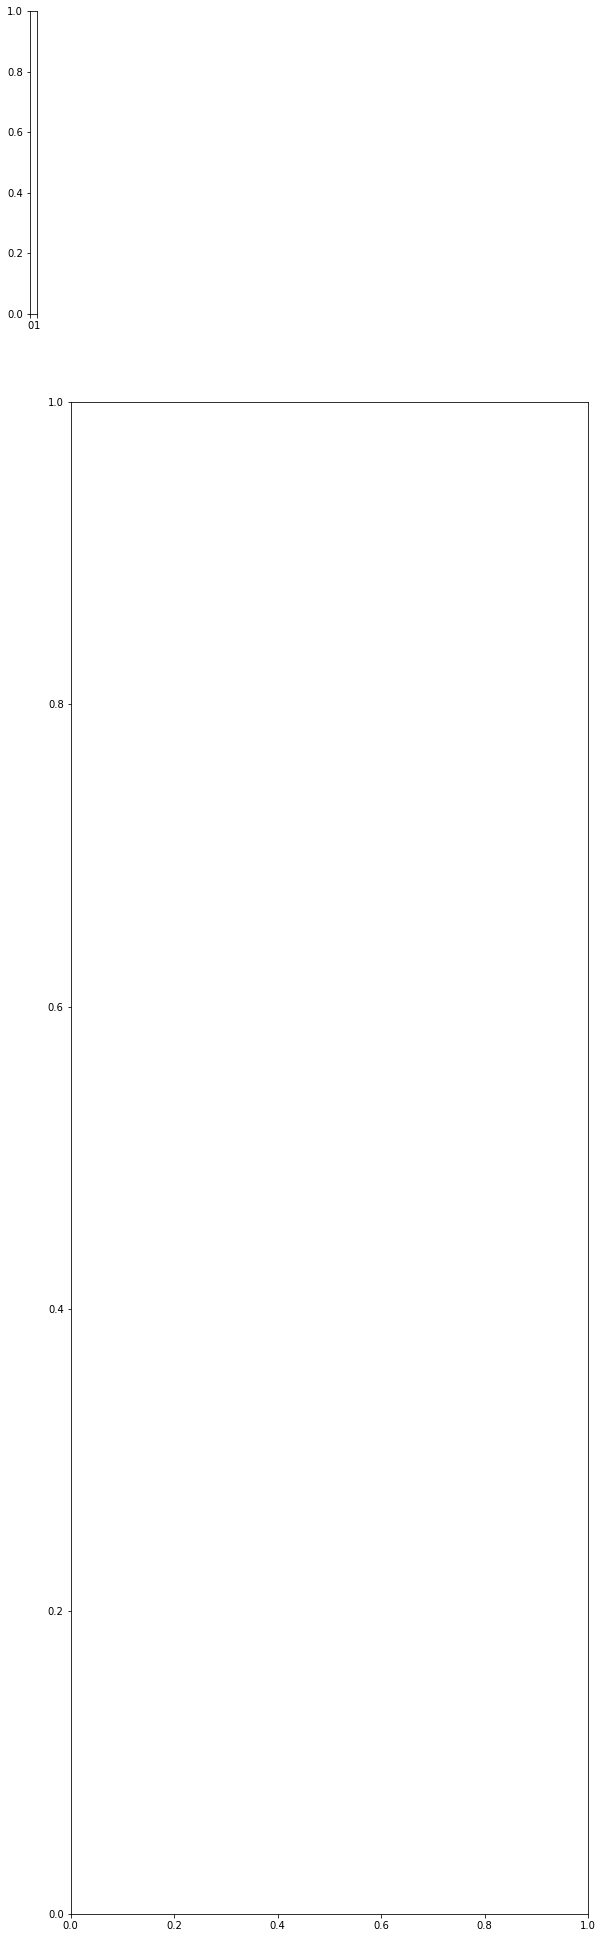

In [69]:

sns.clustermap( sub_df.T , metric= metrics[2] , method=methods[1] , col_cluster=True, row_cluster= False, yticklabels = sub_df.columns , figsize = (10, 35))

ValueError: The number of observations cannot be determined on an empty distance matrix.

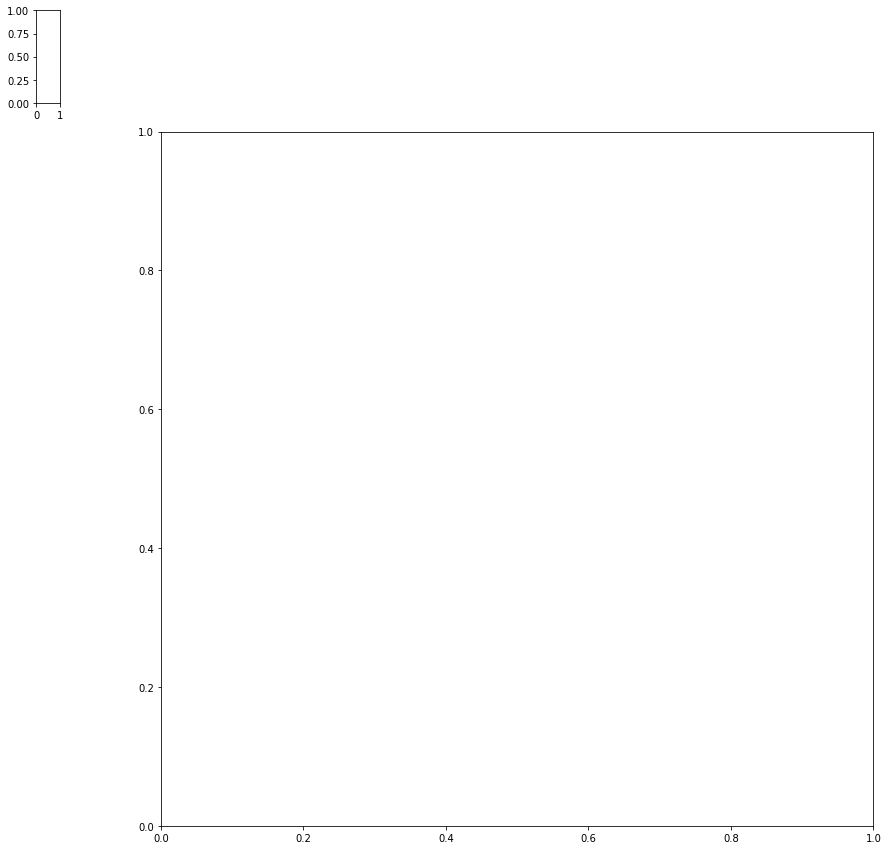

In [70]:
#let's look at the module centric view again
#Its 
distmat = cdist(sub_df.to_numpy(), sub_df.to_numpy() , metric = metrics[2])
sns.clustermap(1- distmat , metric= metrics[0] , method=methods[0] , col_cluster=True, row_cluster= True, yticklabels = sub_df.index , xticklabels = sub_df.index , figsize = (15, 15))

In [71]:
#let's use independent analysis to comfirm 
#fetching expression data from bgee
#If genes are coexpressed across different tissues in similar patterns 
#they are most likely interacting
#This is more particular to each organism and unrelated to their evolutionary history

#we need the BGee cross reference for human
qlist = { query.Entry:query['Cross-reference (Bgee)'].replace(';','') for index,query in queries[['Entry','Cross-reference (Bgee)']].iterrows() if query['Cross-reference (Bgee)'] is not np.nan }
qlists = {'HUMAN': qlist }

# now using some cross references to other organisms
xrefs = {}
#we're going to grab the ensemble IDs for the TOR pathway orthologues from a few species
#These are also present in the Bgee dataset
#Bgee species are listed here https://bgee.org
#species information for OMA is available at https://omabrowser.org/All/oma-species.txt
#Ive selected some interesting species...
#let's grab the xrefs for orthologues in these species
species = [ 'DROME','CAEEL' , 'DANRE' , 'MOUSE' , 'PIGXX']
#... my cat would never forgive me if I didn't include them in the analysis
species +=['FELCA']

#ok let's get the get the uniprot xrefs for each of the sequences
allnames = {}
for q in orthologs:
    for o in orthologs[q]:
        for spec in species:
            if spec not in xrefs:
                xrefs[spec] = {}
            if  o['omaid'][0:5] == spec:
                xrefs[spec][o['omaid'] ] = c.entries.xrefs(o['omaid'])
                if 'UniProtKB/TrEMBL' in xrefs[spec][o['omaid'] ]:
                    names[ xrefs[spec][o['omaid']]['UniProtKB/TrEMBL'][0]] = names[q]
allnames.update(names)


In [72]:
#if we have the 'Ensembl Gene' and 'UniProtKB/TrEMBL' for a gene we can add the genes to a list
#like we did for human. We don't care about version numbers for Ensemble so we'll remove them

import urllib.parse
import urllib.request
def unirequest(ID):
    #this is shamelessly lifted from the uniprot programmatic access page
    url = 'https://www.uniprot.org/uploadlists/'
    params = {
    'from': 'ID',
    'to': 'ENSEMBLGENOME_ID',
    'format': 'tab',
    'query': ID
    }
    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
       response = f.read()
    r = response.decode('utf-8')
    return {r.split()[2]:r.split()[3]}


for spec in species:
    
    #ok...lets try to map everything to ensembl gene IDs
    qlist = {}
    for entry in xrefs[spec]:
        if 'Ensembl Gene' in xrefs[spec][entry]  and 'UniProtKB/TrEMBL' in xrefs[spec][entry]:
            try:
                qlist.update({xrefs[spec][entry]['UniProtKB/TrEMBL'][0] : xrefs[spec][entry]['Ensembl Gene'][0].split('.')[0] })
            except IndexError:
                pass
        elif 'UniProtKB/TrEMBL' in xrefs[spec][entry]:
            try:
                #if we don't have then ensemble ID in OMA
                #we can still try and pull it from uniprot
                qlist.update(unirequest(xrefs[spec][entry]['UniProtKB/TrEMBL'][0]))
            except TypeError:
                pass
            except IndexError:
                pass
        
    qlists.update({spec:qlist})


In [73]:
#here we can pull the information for tissue specific expression for each of our genes using
#a sparql query for using lists of ensemble IDs on BGEE

#Once we retrieve this data we can verify if the clustering of expression patterns recapitulates the
#coevolutionary signal.

from SPARQLWrapper import SPARQLWrapper , CSV
from io import StringIO

endpt = "http://biosoda.expasy.org:8080/rdf4j-server/repositories/bgeelight"
sparql = SPARQLWrapper(endpt)

#here's the template sparql query we're going to be using
#we can add our gene IDs for each species

query = '''
PREFIX orth: <http://purl.org/net/orth#>
PREFIX genex: <http://purl.org/genex#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX lscr: <http://purl.org/lscr#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT distinct ?anat ?anatName ?geneEns{{
    values ?geneEns {{   {0}   }}
	?gene genex:isExpressedIn ?anat .
    ?gene lscr:xrefEnsemblGene ?geneEns.
	?gene rdfs:label ?geneName .
	?anat rdfs:label ?anatName .
}} 
'''

dfs = []
for species in qlists:
    #for each species in our queries
    pre = '<http://rdf.ebi.ac.uk/resource/ensembl/'
    suf = '>'
    #make a list of gene IDs
    ensemblelist = ''.join( [ pre + qlists[species][uniID]  + suf + ' ' for uniID in qlists[species] ] )
    
    #get the Bgee data
    sparql.setQuery(query.format(ensemblelist))
    sparql.setReturnFormat(CSV)
    results = sparql.query().convert()
    #and make a dataframe for our returned results
    sub = pd.read_csv(StringIO(results.decode()) )
    #let's add which species the data came from to our dataframe columns
    sub['species'] = species
    sub['geneEns'] = sub['geneEns'].map(lambda x : x.split('/')[-1])
    
    #lets add the uniprot cannonical IDs into our dataframe as well
    sub['canonicalid'] = sub['geneEns'].map(dict(zip( qlists[species].values(), qlists[species].keys() )))
    #and use these uniprot IDs to map back to our original human derived gene names 
    #to keep everything consistent
    sub['names'] =  sub['canonicalid'].map(names)
    dfs.append(sub)

    
#lets put everything into one big dataframe so we can play around with this data
#we're going to cluster it in a similar way to what we did with
#the OMA data

#yay! we have our data. Let's see if we can find some clusters of coexpressed genes
expressionDF = pd.concat(dfs)


HUMAN
                        anatName  \
0                   hypothalamus   
1  right atrium auricular region   
2              cardiac ventricle   
3               secondary oocyte   
4                 saphenous vein   

                                            anat          geneEns species  \
0  http://purl.obolibrary.org/obo/UBERON_0001898  ENSG00000155760   HUMAN   
1  http://purl.obolibrary.org/obo/UBERON_0006631  ENSG00000205213   HUMAN   
2  http://purl.obolibrary.org/obo/UBERON_0002082  ENSG00000205213   HUMAN   
3      http://purl.obolibrary.org/obo/CL_0000655  ENSG00000039319   HUMAN   
4  http://purl.obolibrary.org/obo/UBERON_0007318  ENSG00000108443   HUMAN   

  canonicalid                                         names  
0      O75084  FZD7 canonical Wnt signaling pathway [60070]  
1      Q9BXB1  LGR4 canonical Wnt signaling pathway [60070]  
2      Q9BXB1  LGR4 canonical Wnt signaling pathway [60070]  
3      Q7Z3T8           ZFY16 BMP signaling pathway [30509]  
4   

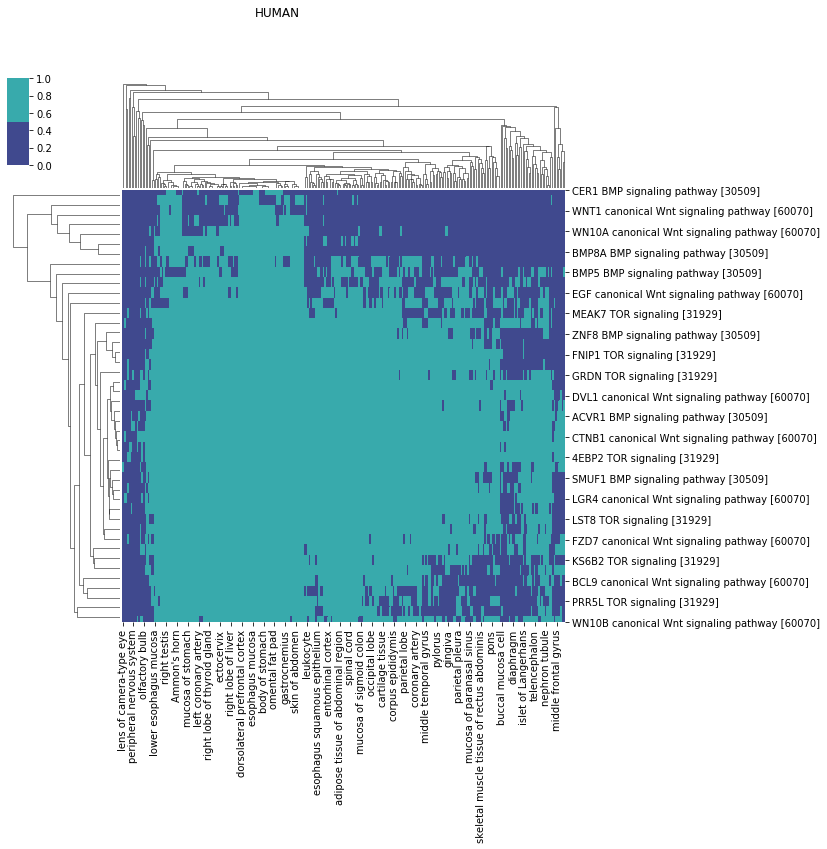

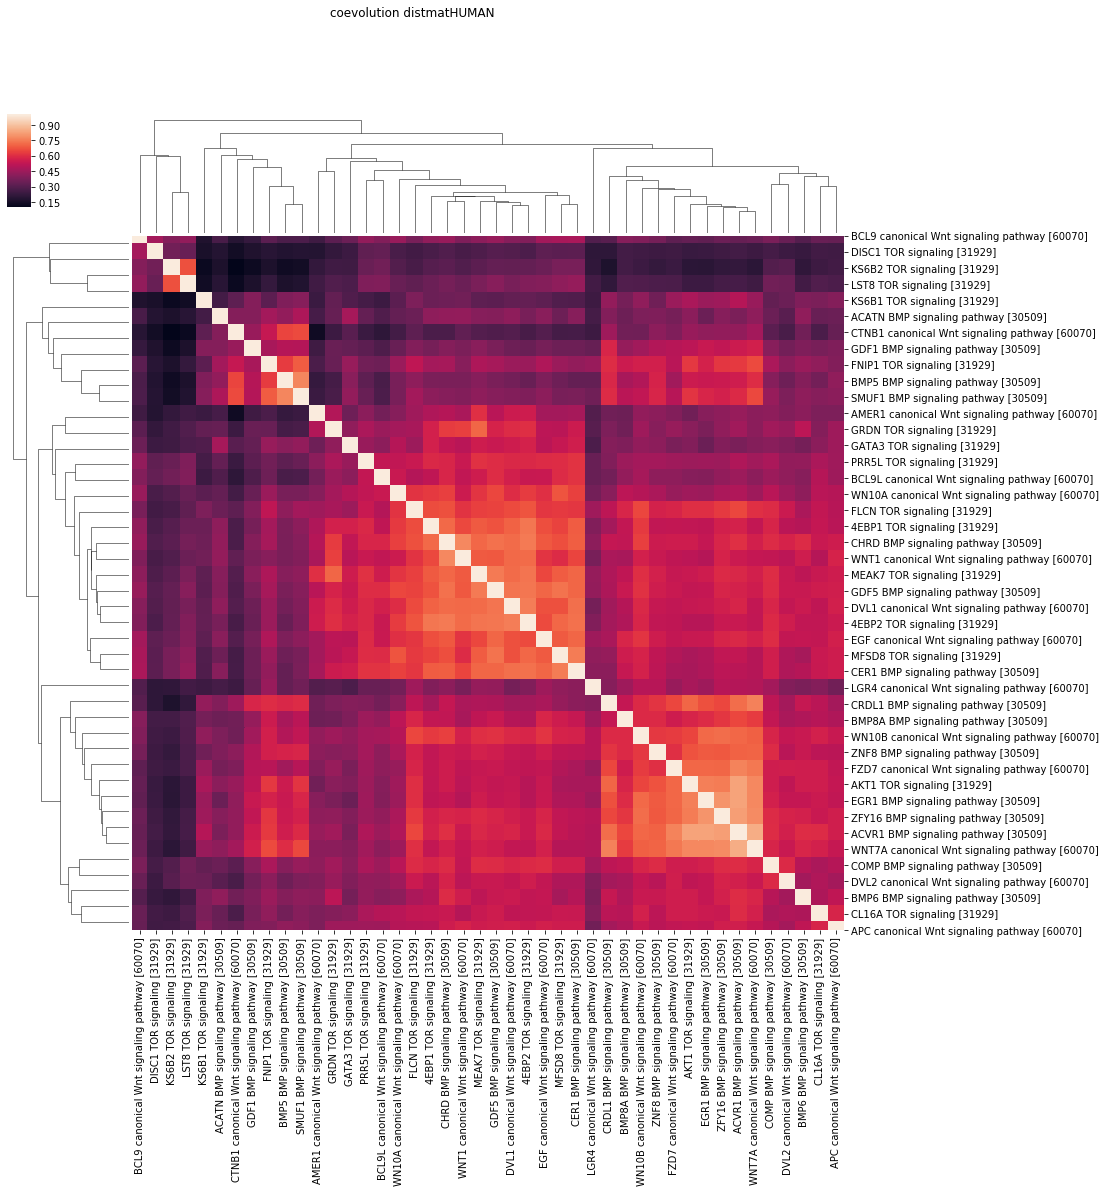

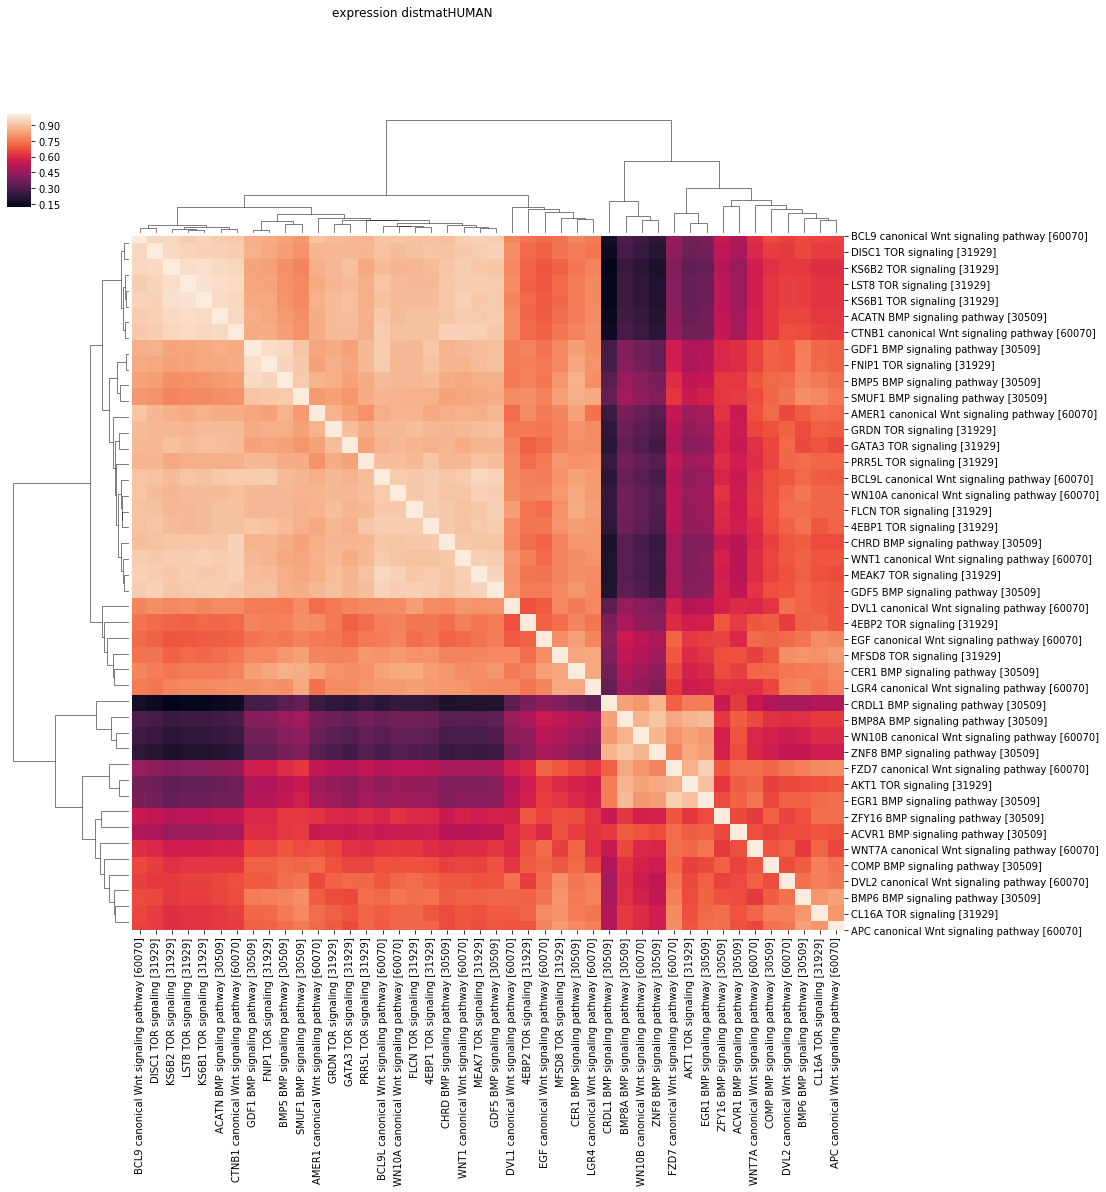

 do our matrices match from one approach to the other? 
Pearson:(0.07363490124408432, 0.0011859192563835115)
DROME
                               anatName  \
0                                 brain   
1  embryonic deutocerebrum (Drosophila)   
2                 eye disc (Drosophila)   
3        visual primordium (Drosophila)   
4                    tagma (Drosophila)   

                                            anat      geneEns species  \
0  http://purl.obolibrary.org/obo/UBERON_0000955  FBgn0264691   DROME   
1   http://purl.obolibrary.org/obo/FBbt_00001067  FBgn0000233   DROME   
2   http://purl.obolibrary.org/obo/FBbt_00001768  FBgn0264691   DROME   
3   http://purl.obolibrary.org/obo/FBbt_00001059  FBgn0261560   DROME   
4   http://purl.obolibrary.org/obo/FBbt_00000002  FBgn0001085   DROME   

  canonicalid                                         names  
0      B4F5L6                    LST8 TOR signaling [31929]  
1      Q24266            EGR1 BMP signaling pathway [30509]  
2

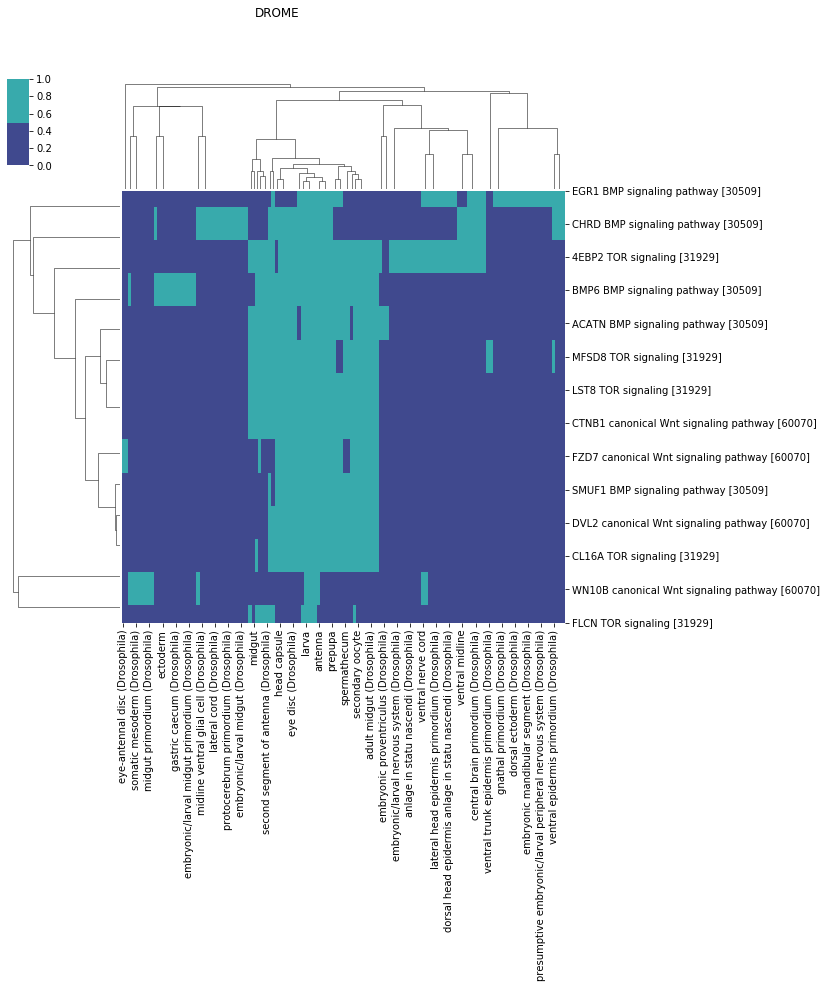

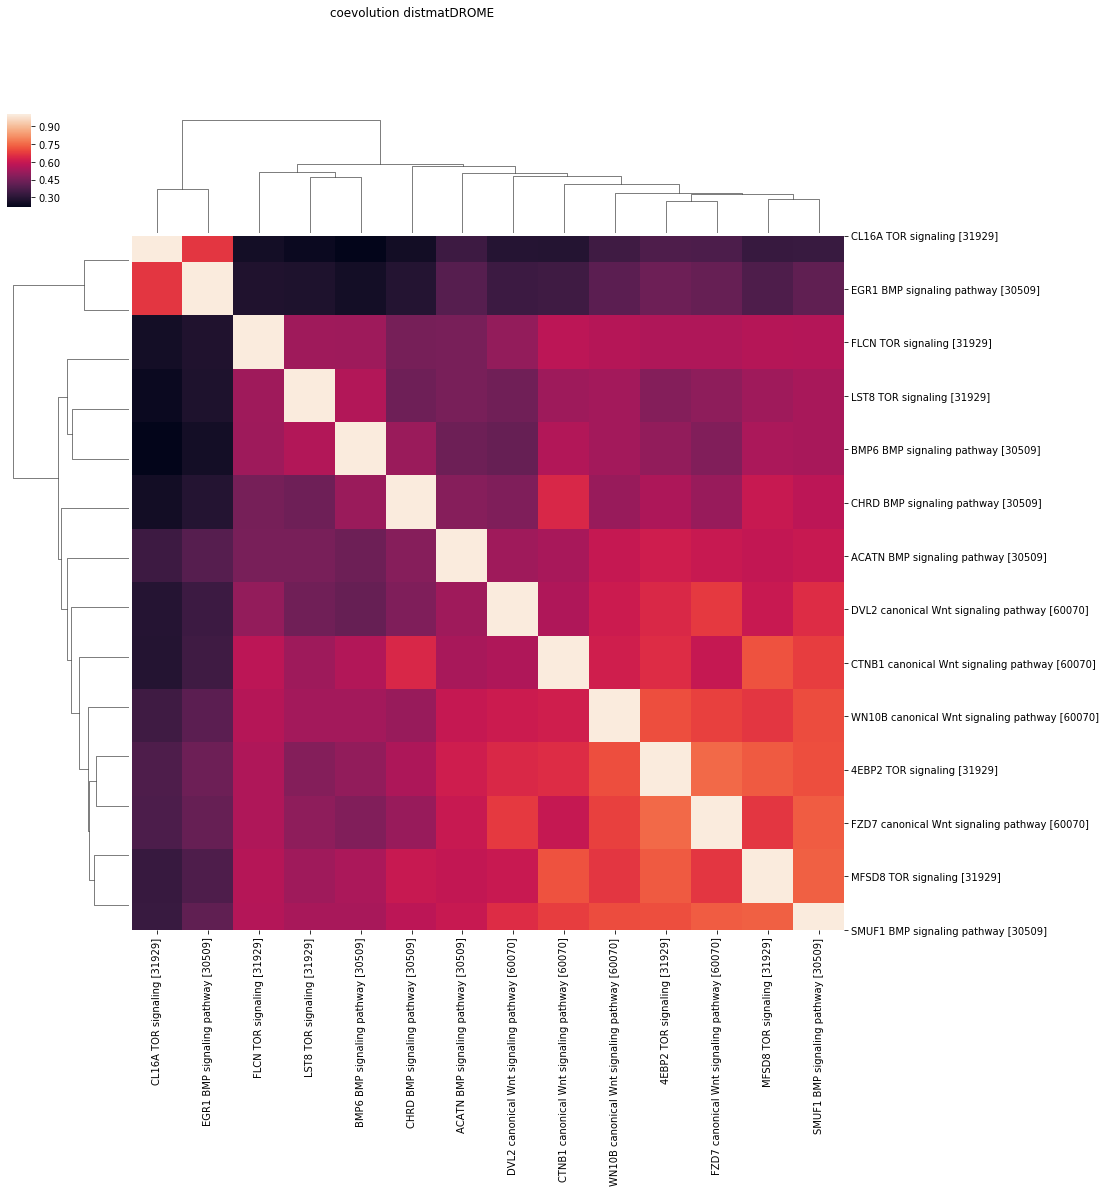

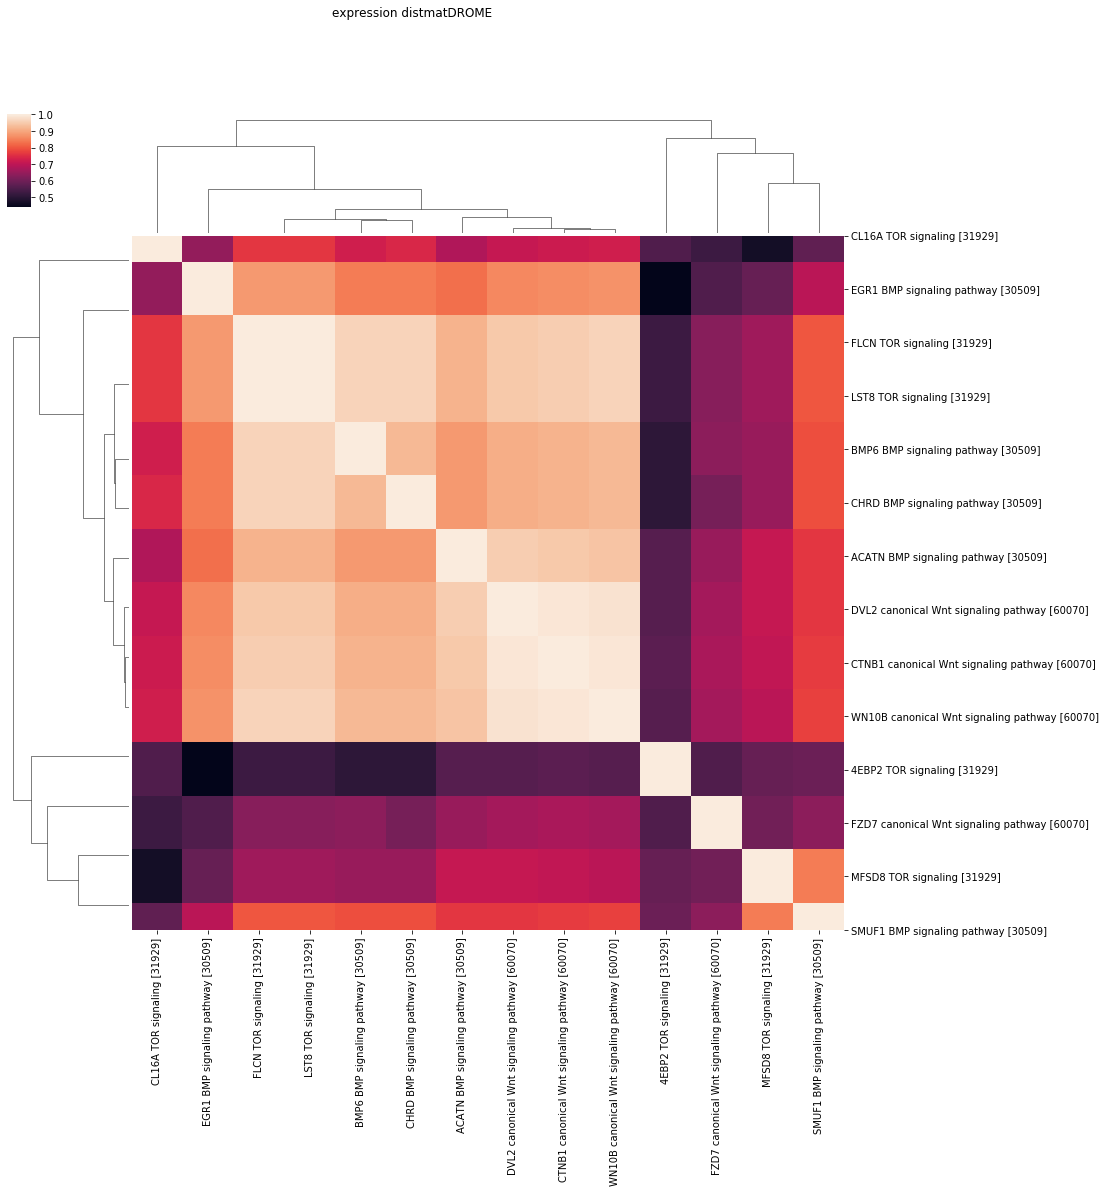

 do our matrices match from one approach to the other? 
Pearson:(0.198173573839985, 0.005363464652488899)
CAEEL
                             anatName  \
0                      adult organism   
1             multi-cellular organism   
2                      adult organism   
3                               gonad   
4  pharyngeal muscle cell (C elegans)   

                                            anat         geneEns species  \
0  http://purl.obolibrary.org/obo/UBERON_0007023  WBGene00003397   CAEEL   
1  http://purl.obolibrary.org/obo/UBERON_0000468  WBGene00001979   CAEEL   
2  http://purl.obolibrary.org/obo/UBERON_0007023  WBGene00001660   CAEEL   
3  http://purl.obolibrary.org/obo/UBERON_0000991  WBGene00003397   CAEEL   
4    http://purl.obolibrary.org/obo/WBbt_0005451  WBGene00003397   CAEEL   

  canonicalid                                          names  
0  A0A0K3AWM6   FZD7 canonical Wnt signaling pathway [60070]  
1      H2L2I2  CTNB1 canonical Wnt signaling pathway [6007

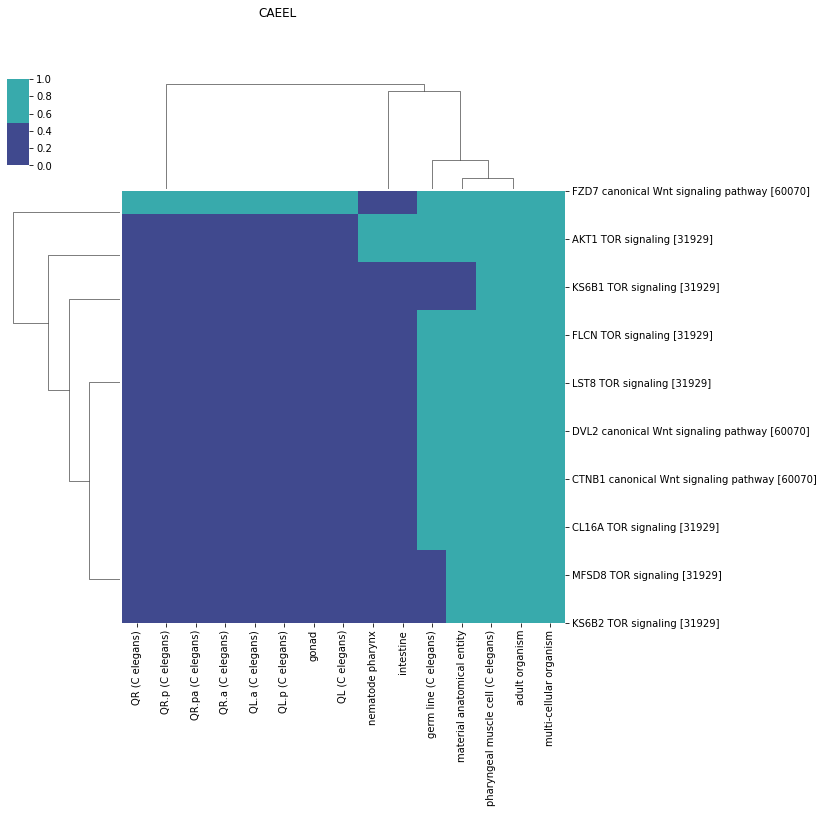

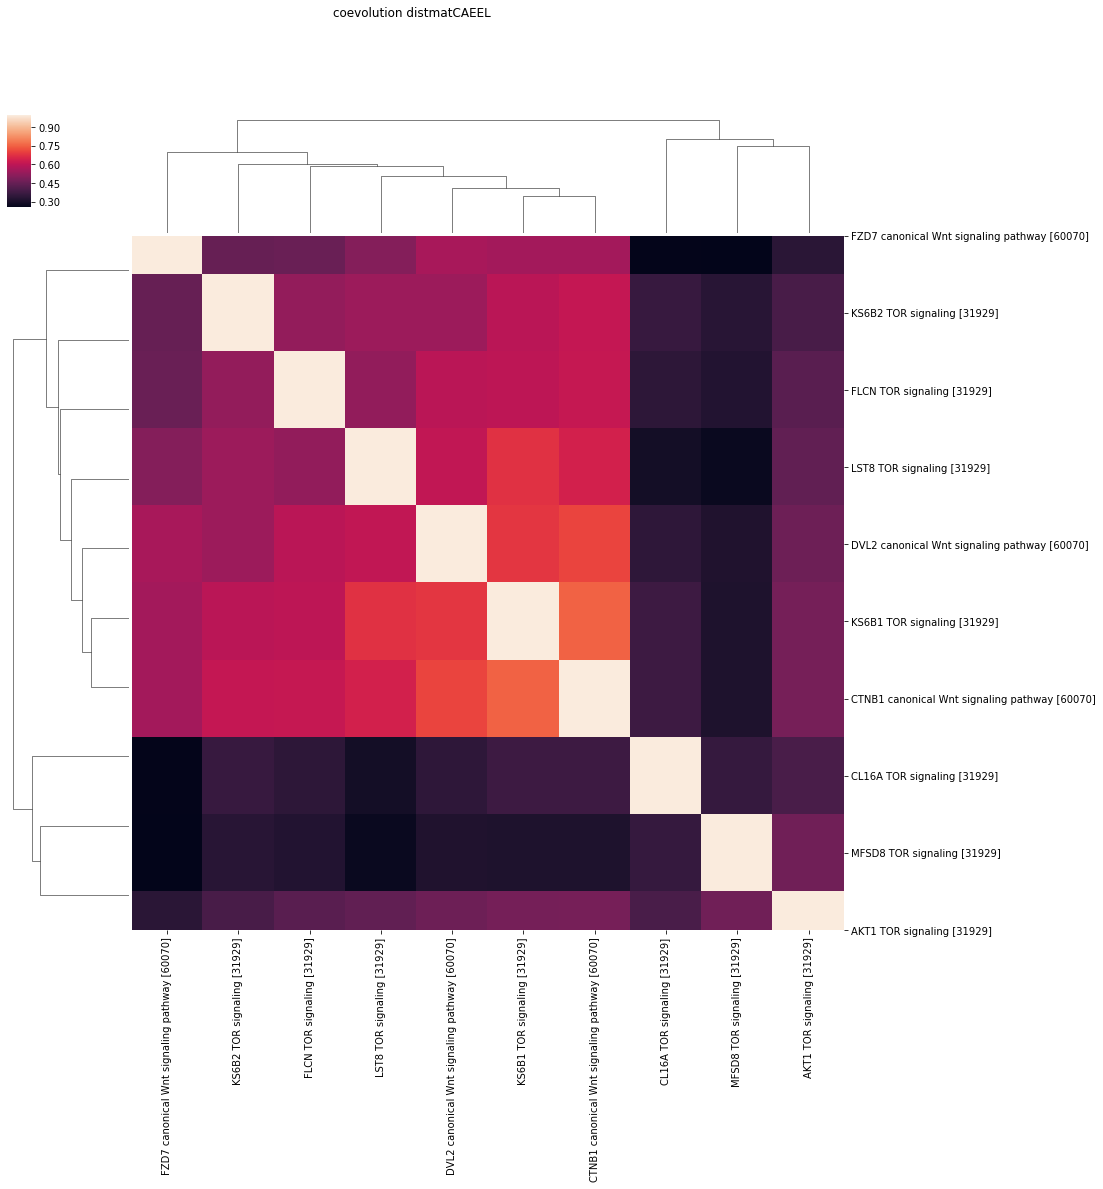

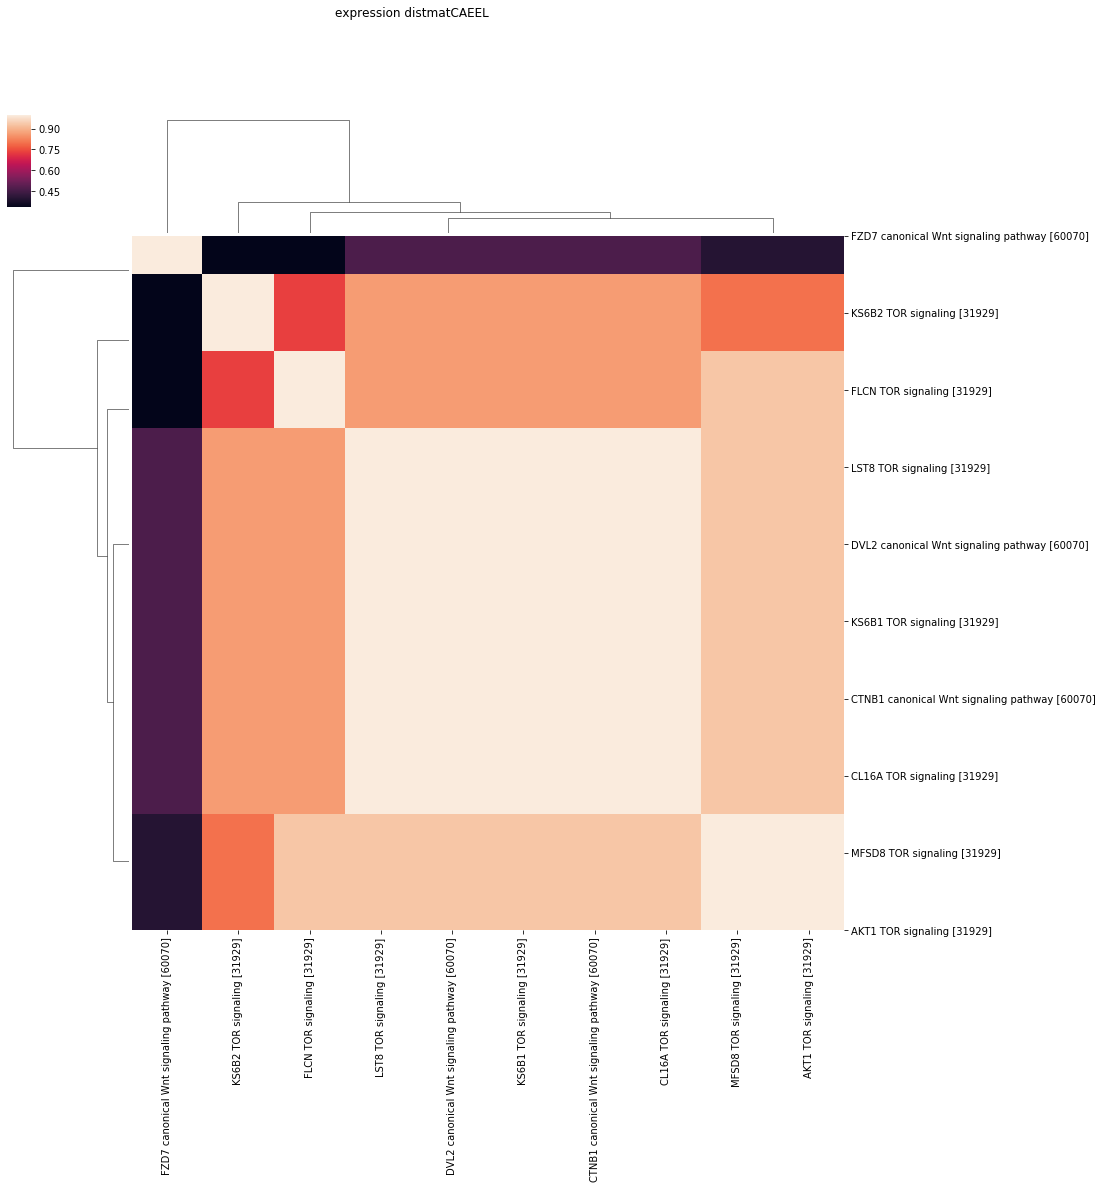

 do our matrices match from one approach to the other? 
Pearson:(0.06770993974535927, 0.5032688249752185)
DANRE
                 anatName                                           anat  \
0                   larva  http://purl.obolibrary.org/obo/UBERON_0002548   
1         pharyngeal arch  http://purl.obolibrary.org/obo/UBERON_0002539   
2             endocardium  http://purl.obolibrary.org/obo/UBERON_0002165   
3                   heart  http://purl.obolibrary.org/obo/UBERON_0000948   
4  eye photoreceptor cell      http://purl.obolibrary.org/obo/CL_0000287   

              geneEns species canonicalid  \
0  ENSDARG00000062385   DANRE      E9QIZ9   
1  ENSDARG00000027589   DANRE      Q8QFM3   
2  ENSDARG00000037421   DANRE      B3DKJ7   
3  ENSDARG00000058868   DANRE      F8W4Z3   
4  ENSDARG00000037421   DANRE      B3DKJ7   

                                          names  
0                    FLCN TOR signaling [31929]  
1  FZD7 canonical Wnt signaling pathway [60070]  
2         

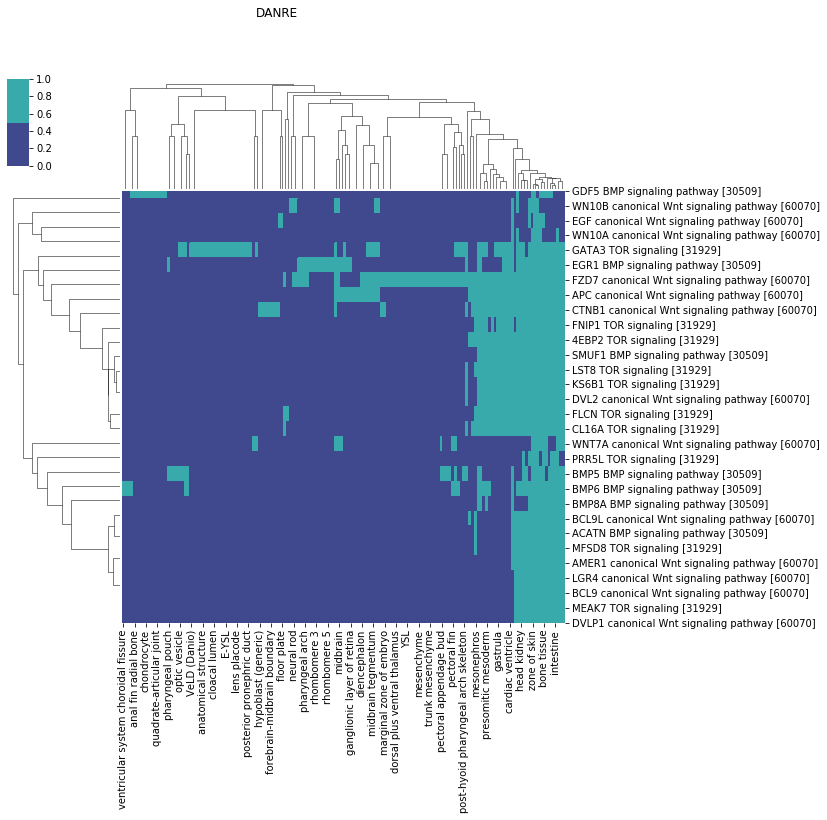

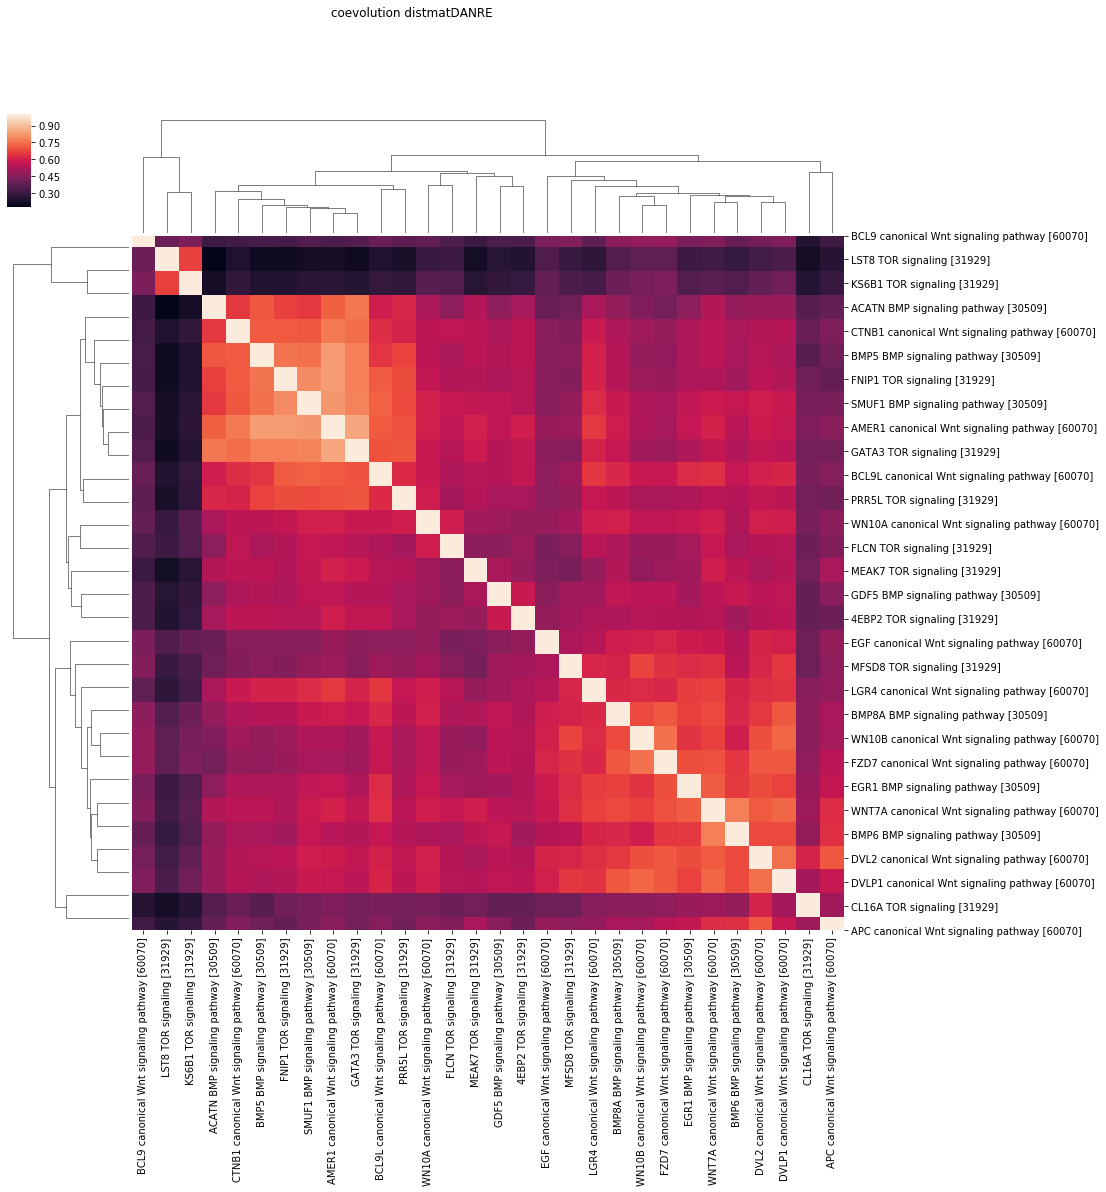

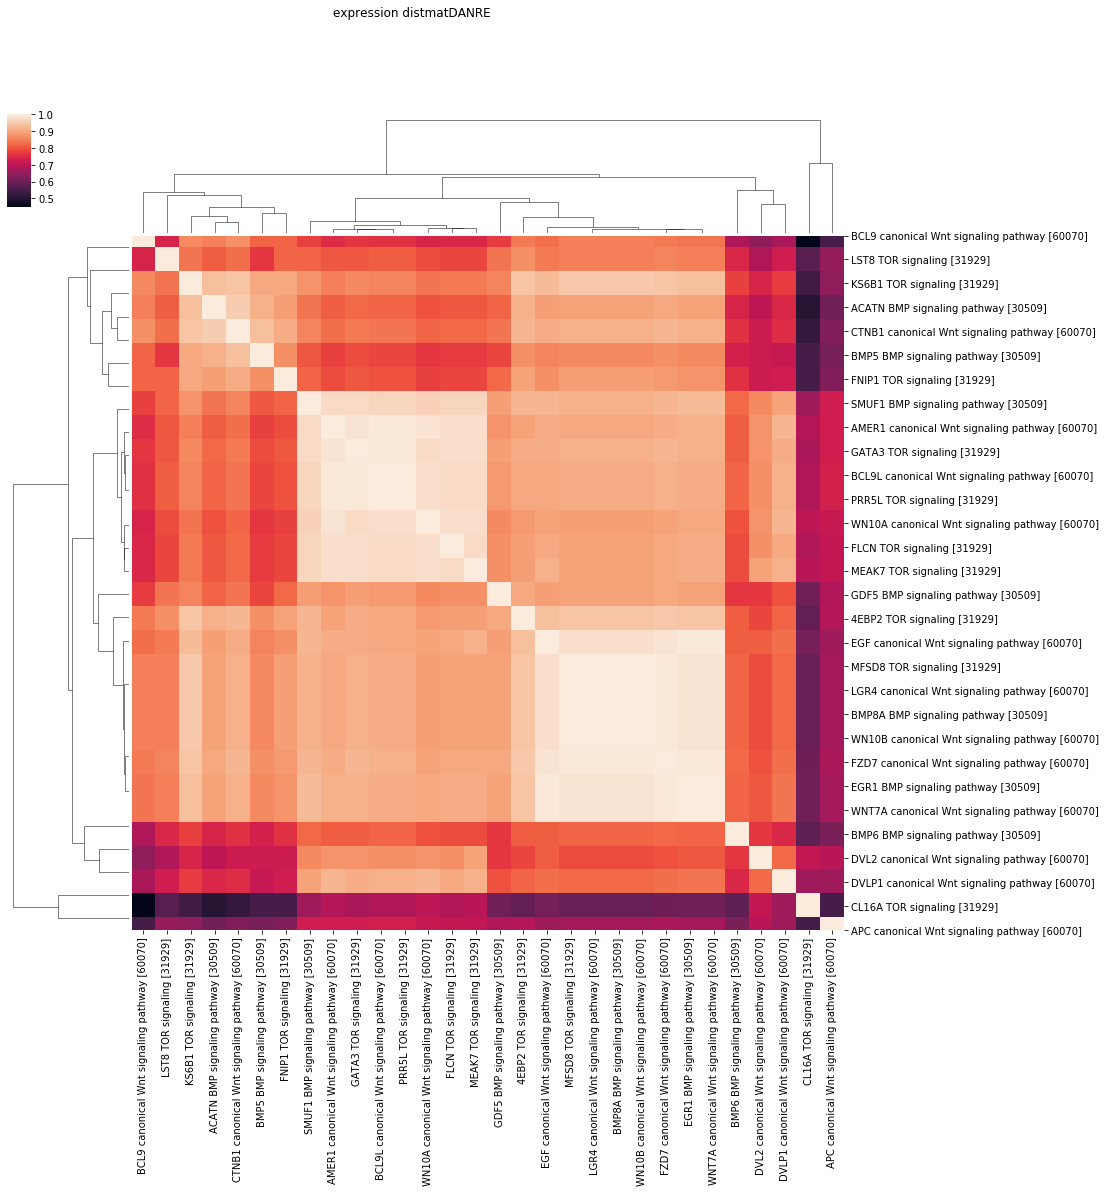

 do our matrices match from one approach to the other? 
Pearson:(0.4622304459692345, 7.733340778761355e-49)
MOUSE
                              anatName  \
0                                manus   
1  migratory enteric neural crest cell   
2                             pancreas   
3                               retina   
4                               embryo   

                                            anat             geneEns species  \
0  http://purl.obolibrary.org/obo/UBERON_0002398  ENSMUSG00000020091   MOUSE   
1      http://purl.obolibrary.org/obo/CL_0002607  ENSMUSG00000032179   MOUSE   
2  http://purl.obolibrary.org/obo/UBERON_0001264  ENSMUSG00000024142   MOUSE   
3  http://purl.obolibrary.org/obo/UBERON_0000966  ENSMUSG00000028017   MOUSE   
4  http://purl.obolibrary.org/obo/UBERON_0000922  ENSMUSG00000068663   MOUSE   

  canonicalid                                        names  
0      P70445                  4EBP2 TOR signaling [31929]  
1      P49003           BMP5 B

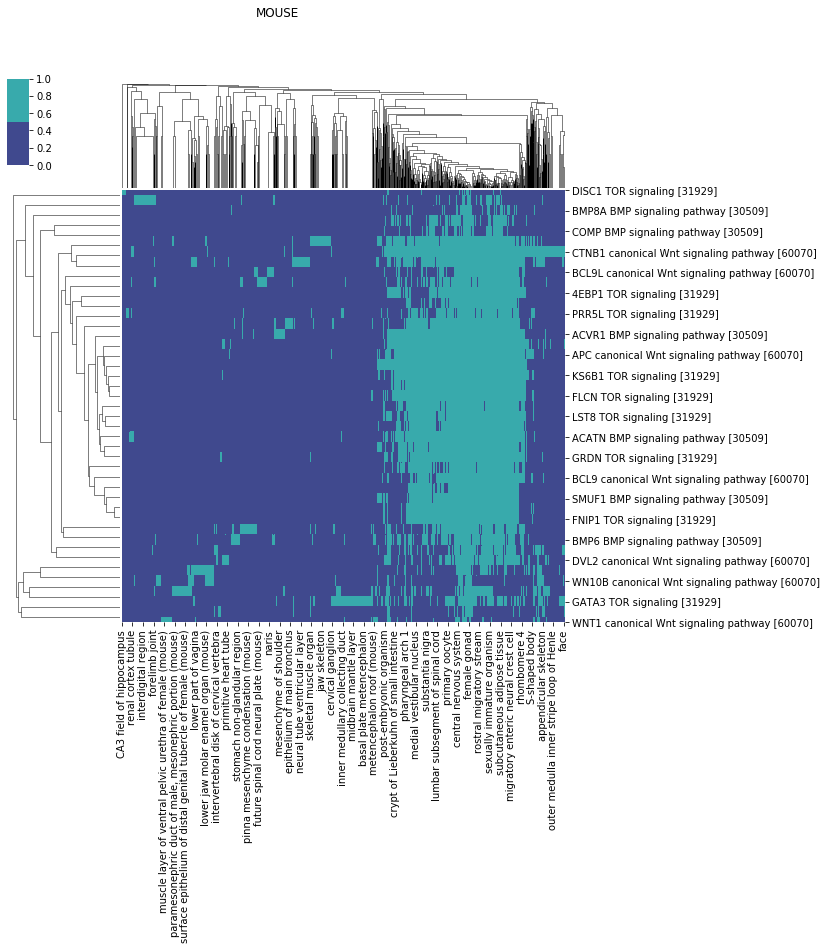

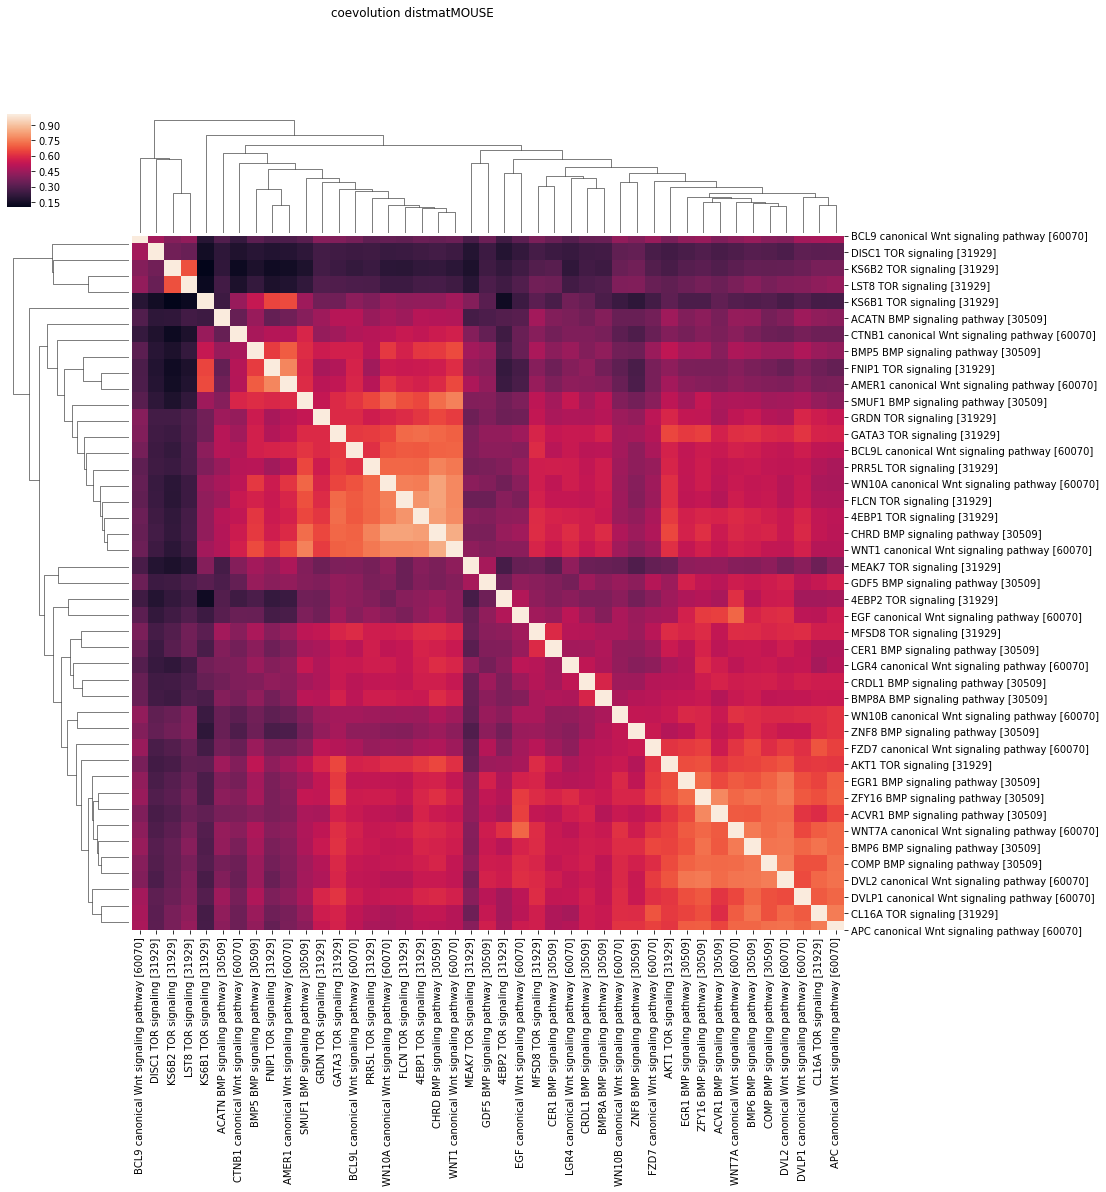

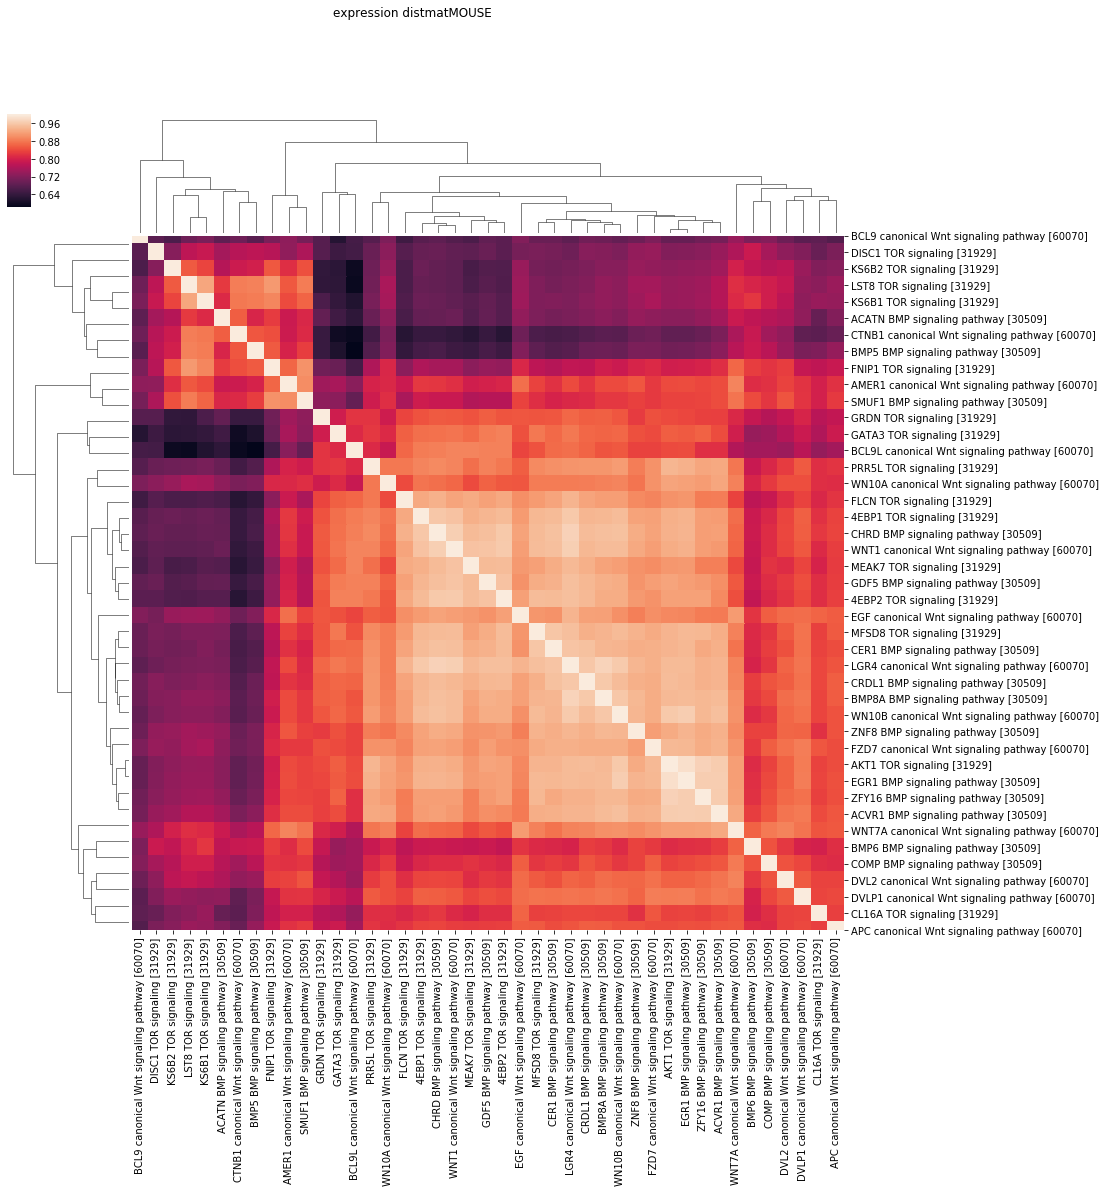

 do our matrices match from one approach to the other? 
Pearson:(0.05710212009443144, 0.014059697935764306)
PIGXX
            anatName                                           anat  \
0             kidney  http://purl.obolibrary.org/obo/UBERON_0002113   
1              liver  http://purl.obolibrary.org/obo/UBERON_0002107   
2               lung  http://purl.obolibrary.org/obo/UBERON_0002048   
3  prefrontal cortex  http://purl.obolibrary.org/obo/UBERON_0000451   
4  prefrontal cortex  http://purl.obolibrary.org/obo/UBERON_0000451   

              geneEns species canonicalid  \
0  ENSSSCG00000017670   PIGXX  A0A481C7T7   
1  ENSSSCG00000030153   PIGXX  A0A4X1U770   
2  ENSSSCG00000030153   PIGXX  A0A4X1U770   
3  ENSSSCG00000000182   PIGXX  A0A4X1WDV6   
4  ENSSSCG00000003342   PIGXX  A0A4X1WAB8   

                                           names  
0                    KS6B1 TOR signaling [31929]  
1            SMUF1 BMP signaling pathway [30509]  
2            SMUF1 BMP signaling pa

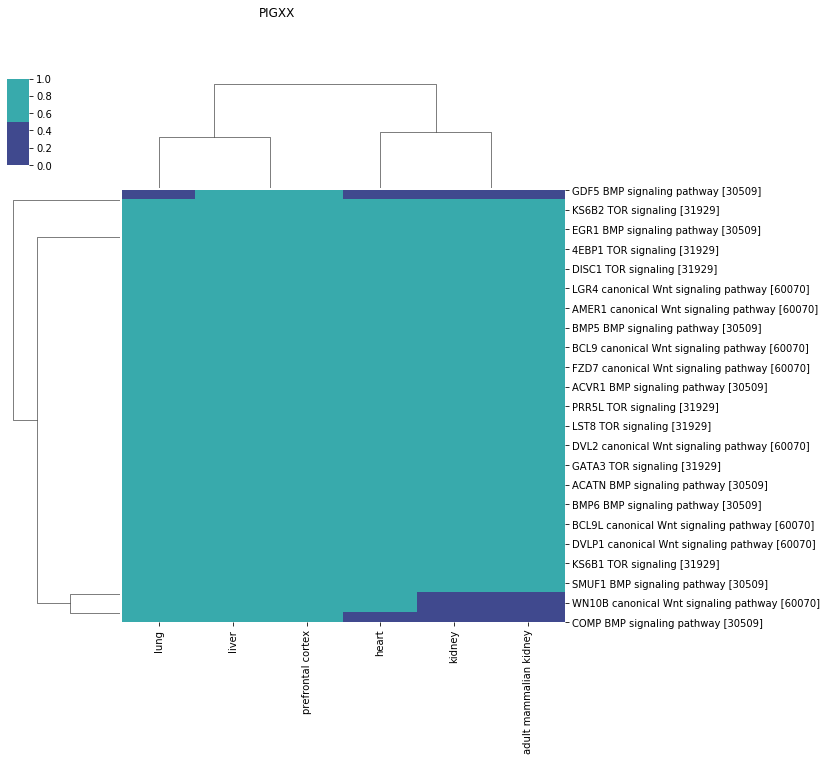

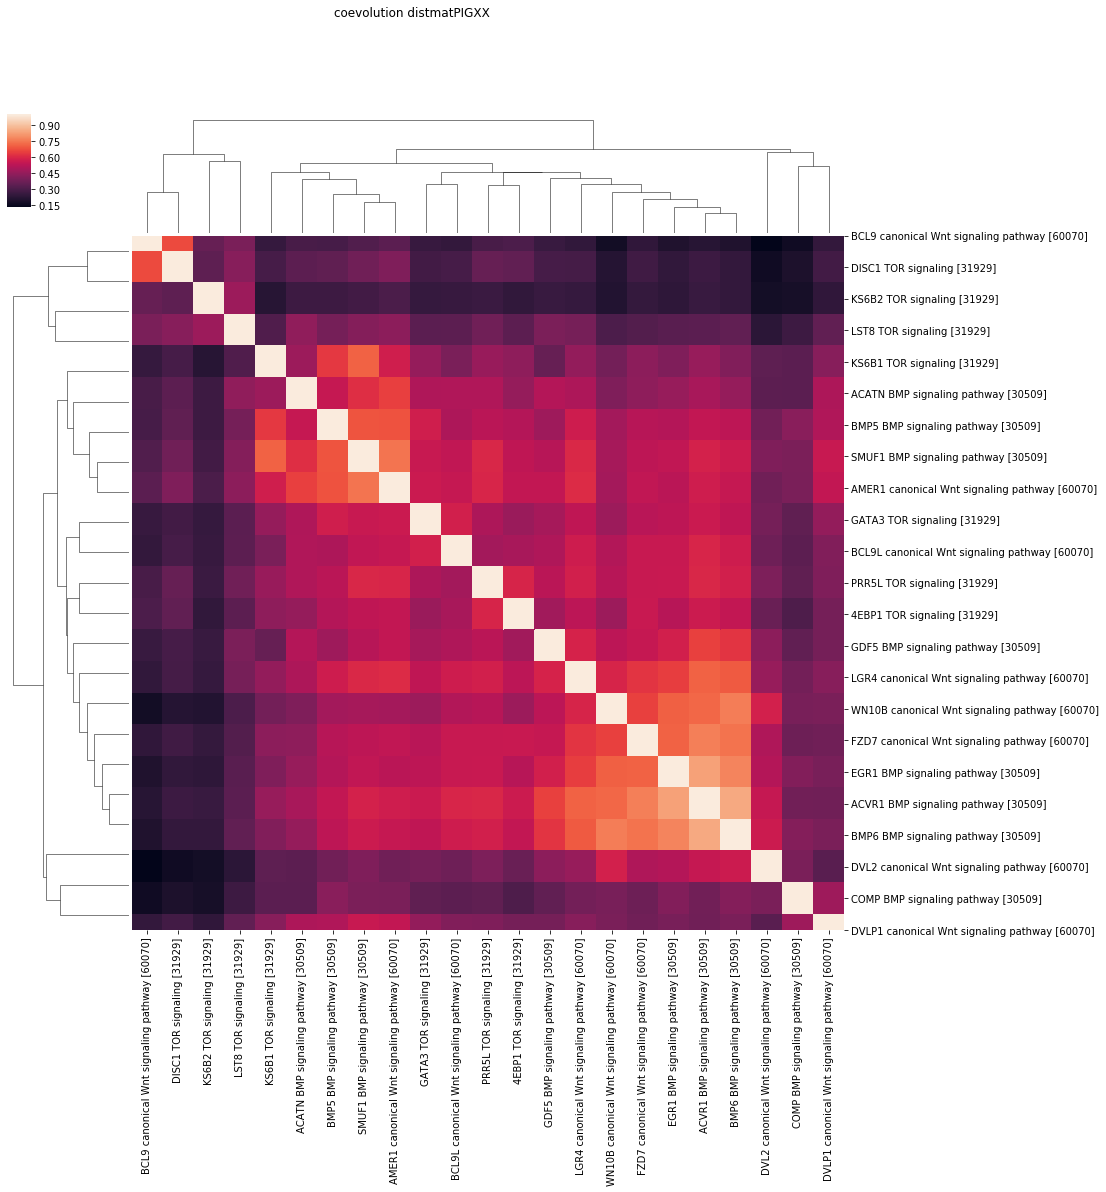

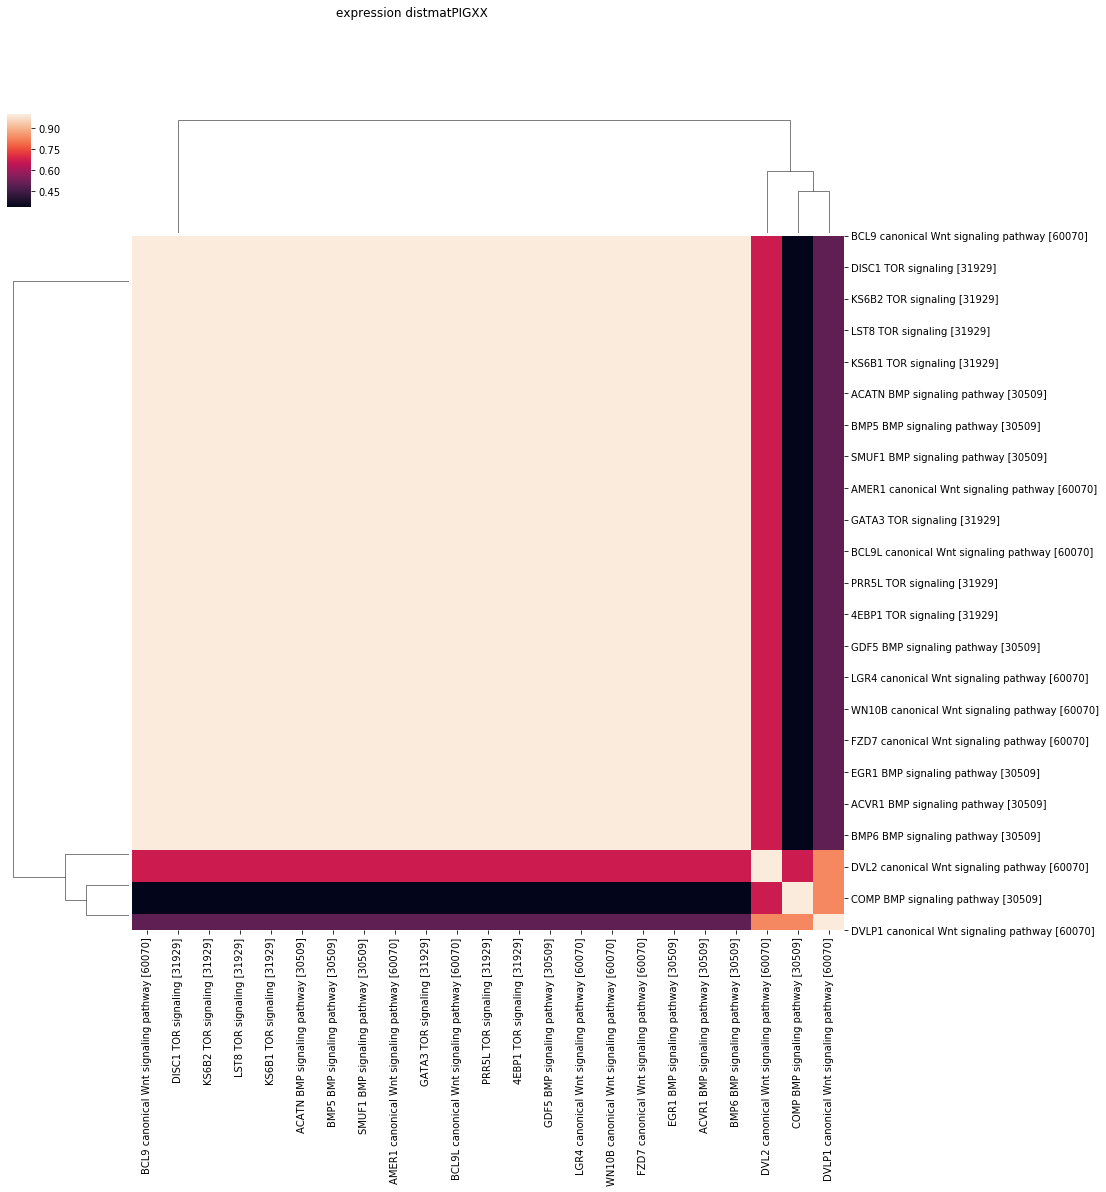

 do our matrices match from one approach to the other? 
Pearson:(0.20230839817682172, 2.7230454848625835e-06)
FELCA
            anatName                                           anat  \
0  prefrontal cortex  http://purl.obolibrary.org/obo/UBERON_0000451   
1  prefrontal cortex  http://purl.obolibrary.org/obo/UBERON_0000451   
2              liver  http://purl.obolibrary.org/obo/UBERON_0002107   
3  prefrontal cortex  http://purl.obolibrary.org/obo/UBERON_0000451   
4  prefrontal cortex  http://purl.obolibrary.org/obo/UBERON_0000451   

              geneEns species canonicalid                               names  
0  ENSFCAG00000028521   FELCA  A0A337SRV2  CER1 BMP signaling pathway [30509]  
1  ENSFCAG00000003395   FELCA      M3W099         KS6B2 TOR signaling [31929]  
2  ENSFCAG00000028983   FELCA  A0A2I2UIE8         PRR5L TOR signaling [31929]  
3  ENSFCAG00000028983   FELCA  A0A2I2UIE8         PRR5L TOR signaling [31929]  
4  ENSFCAG00000024979   FELCA  A0A2I2URW3  GDF5 BMP signa

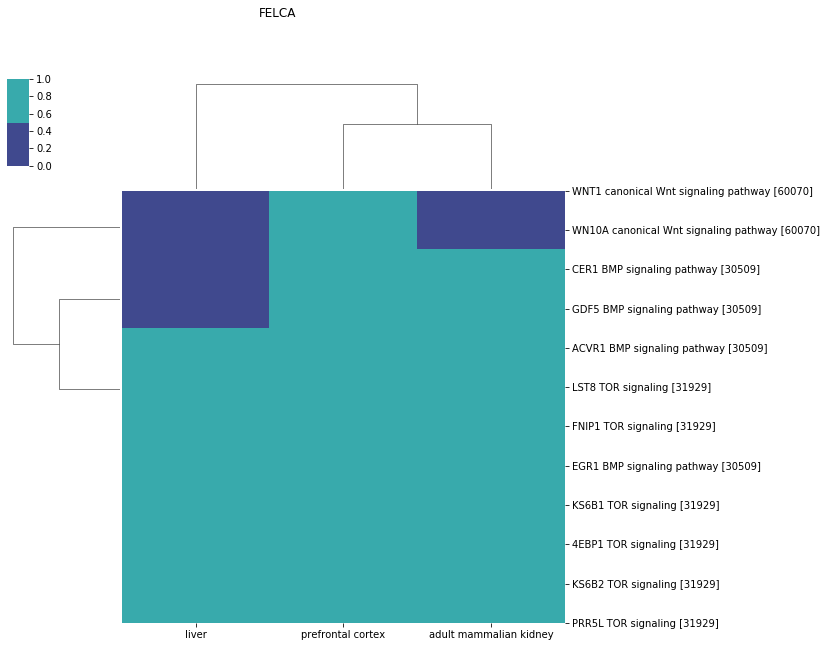

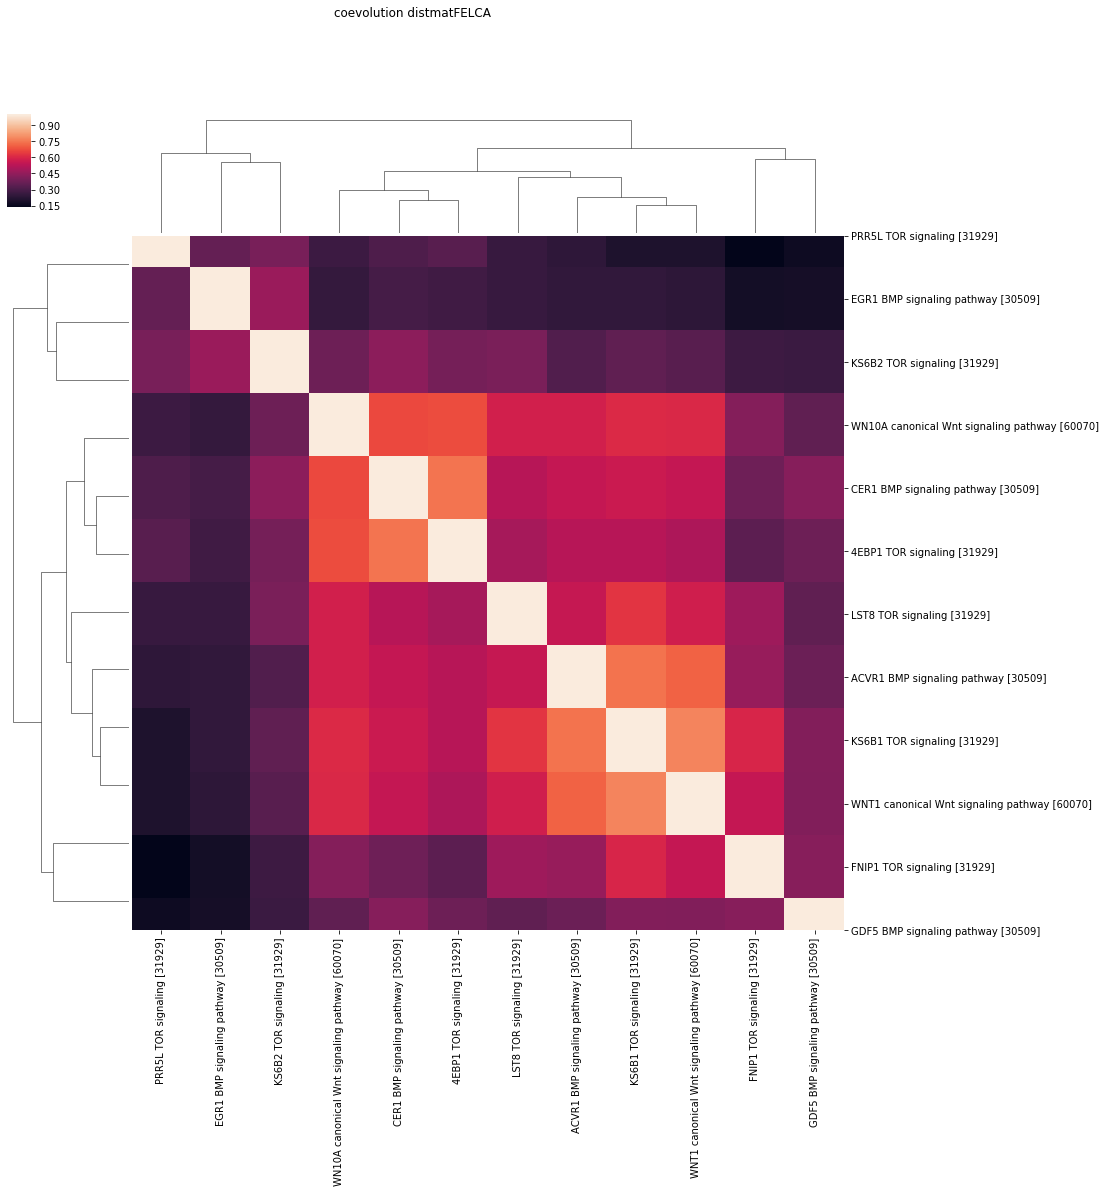

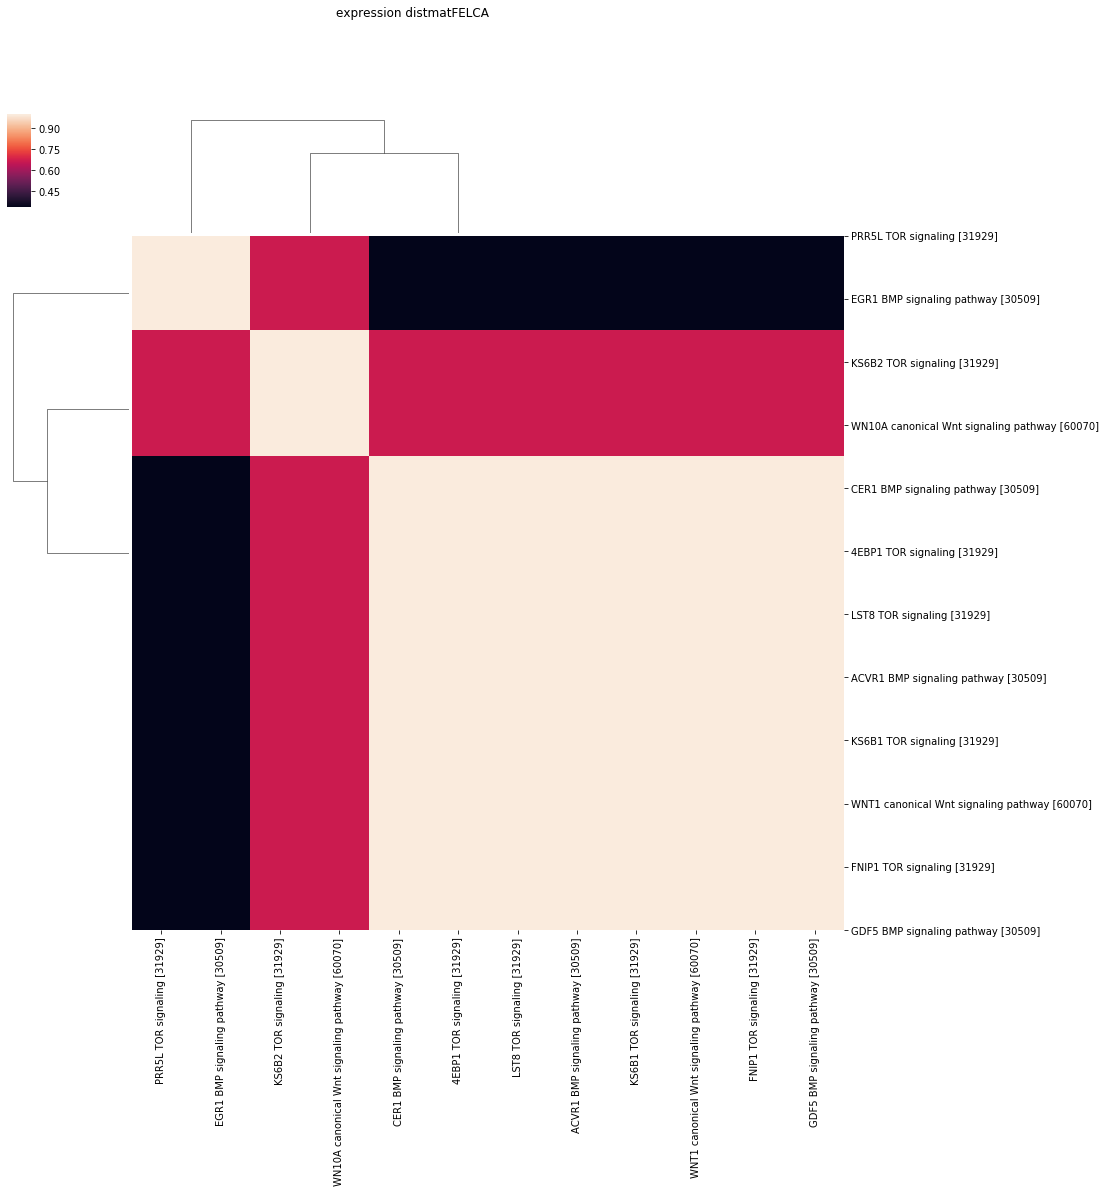

 do our matrices match from one approach to the other? 
Pearson:(0.15302324862880853, 0.06708940801357059)


In [76]:
#now for the results of our efforts!
#let's see if the expression data shows the same pattern as our evolutionary profile comparison

#we can also try to see if the match between our distance matrices is significant between approaches
#the most informative comparison is to check between evolutionary and expression based distances
#If they are significantly similar we can be fairly certain there's an underlying 
#biological network driving this signal

from scipy.stats import pearsonr , spearmanr


for spec in expressionDF.species.unique():
    selected = set()
    #lets look at the clustering of the expression data for each species
    print(spec)
    
    
    sub = expressionDF[expressionDF.species == spec]
    #we can create another dataframe which shows the genes expressed in each tissue
    print(sub.head())
    #each row is a gene
    #each column is a tissue
    
    #we only consider tissues where at least one of the genes is expressed
    rows = list(sub.names.unique())
    columns = list(sub.anatName.unique())
    
    expr_mat = {r :{ c : 0 for c in columns  } for r in rows }
    
    #lets set all of the places where each gene is expressed to 1
    for i,r in sub.iterrows():
        selected.add(r.names)
        expr_mat[r.names][r.anatName] = 1
    
    #and transform everything into a dataframe
    expr_mat = pd.DataFrame.from_dict( expr_mat , orient='index' )
    
    
    print(expr_mat.head())
    print(selected)
    
    
    #and use seaborn again to generate a clustered heatmap figure
    #to show similarity in expression patterns across tissues
    
    g = sns.clustermap( expr_mat , metric= metrics[2] , method=methods[1] , col_cluster=True, row_cluster= True , cmap = sns.color_palette("mako", 2))
    g.fig.suptitle(spec)
    g.savefig( spec+'expcluster.svg')
    plt.show()
    
    sub_orthodf = orthosdf.loc[selected]

    
    distmat_ortho = cdist(sub_orthodf.to_numpy(), sub_orthodf.to_numpy() , metric = metrics[2])
    
    g = sns.clustermap( 1-distmat_ortho , metric= metrics[0] , method=methods[1] , col_cluster=True, row_cluster= True, yticklabels = selected , xticklabels = selected , figsize = (15, 15)  )
    g.fig.suptitle( 'coevolution distmat' + spec) 
    plt.show()
    
    
    
    distmat_expr = cdist(expr_mat.to_numpy(), expr_mat.to_numpy() , metric = metrics[1])
    g = sns.clustermap( 1-distmat_expr , metric= metrics[0] , method=methods[1] , col_cluster=True, row_cluster= True, yticklabels = selected, xticklabels =selected , figsize = (15, 15) )
    g.fig.suptitle( 'expression distmat' + spec ) 

    plt.show()
    
    print( ' do our matrices match from one approach to the other? ')
    print( 'Pearson:'+ str( pearsonr( 1-distmat_ortho.ravel() , 1-distmat_expr.ravel() )  ) ) 
    